# Задание
Используя данные из архива data.zip попробуйте обучить модель SARIMA для всех трех наборов данных. 

Попробуйте:
* подобрать наилучшие коэффициенты самостоятельно или используя auto_arima. 
* добавить в модель дополнительную переменную “День недели”, оцените как изменилась точность модели после этого. 


# Import


In [ ]:
!pip install pmdarima

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import  pmdarima as pm
import joblib

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('fivethirtyeight')

## Utils

### Декомпозиция сезонности
1. Исходные данные 
2. Тренд         - Trend
3. Сезональность - Seasonal
4. Остатки       - Resid

In [96]:
def plotSeasonalDecompose(df, column, target_period):
    # Perform additive decomposition
    decomp = seasonal_decompose(df[column], period=target_period)

    # Plot decomposition
    decomp.plot()
    plt.tight_layout()

### Нормализация

In [99]:
def dfNormalization(df, period):
    df_diff = df.diff() # убираем тренд
    df_diff = df_diff.diff(12) # убираем сезональность
    df_diff = df_diff.dropna() # убираем начальные NA от сдвига на 12
    return df_diff

### Диагностика модели

In [124]:
def modelDiagnostics(results):
    results.summary()

    # Standartized residual - остатки модели, модель обучена хорошо если нет повторяющегося шаблона в графике
    results.plot_diagnostics(figsize=(20, 15))
    plt.tight_layout()

### Создание модели из auto_arima с днями недели

In [ ]:
def createModelSARIMAXex(model_params, endog):
    exog = [day.weekday() for day in endog.index]
    model = SARIMAX(endog=endog, 
                    exog=exog,
                    order=model_params.order, # несезональные параметры
                    seasonal_order=model_params.seasonal_order) # сезональные параметры
    result = model.fit()
    display(result.summary())
    modelDiagnostics(result)


# Dataset milk_production

## Загрузка данных

pounds_per_cow
Month                     
1962-01-01             589
1962-02-01             561
1962-03-01             640
1962-04-01             656
1962-05-01             727
...                    ...
1975-08-01             858
1975-09-01             817
1975-10-01             827
1975-11-01             797
1975-12-01             843

[168 rows x 1 columns]

<AxesSubplot:xlabel='Month'>

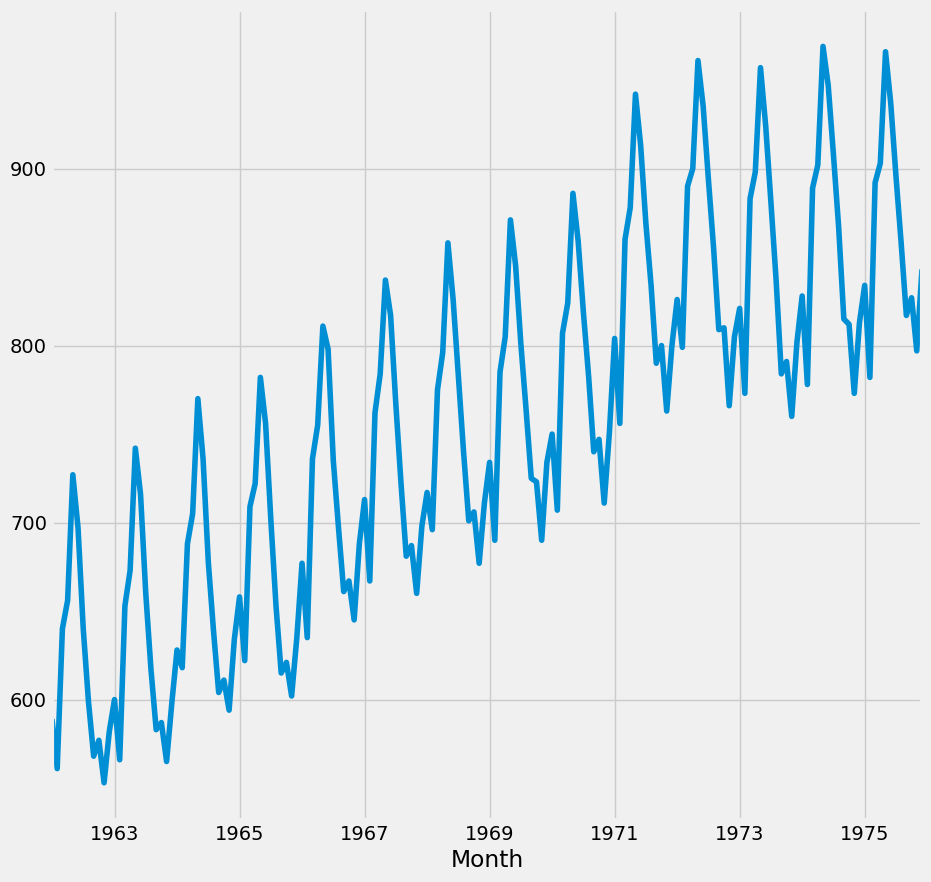

In [51]:
milk_production = pd.read_csv('data/milk_production.csv', index_col='Month', parse_dates=True)
milk_production.columns = ['_','pounds_per_cow']
milk_production = milk_production.drop('_', axis=1)

display(milk_production)
milk_production.pounds_per_cow.plot()

### Декомпозиция сезонности

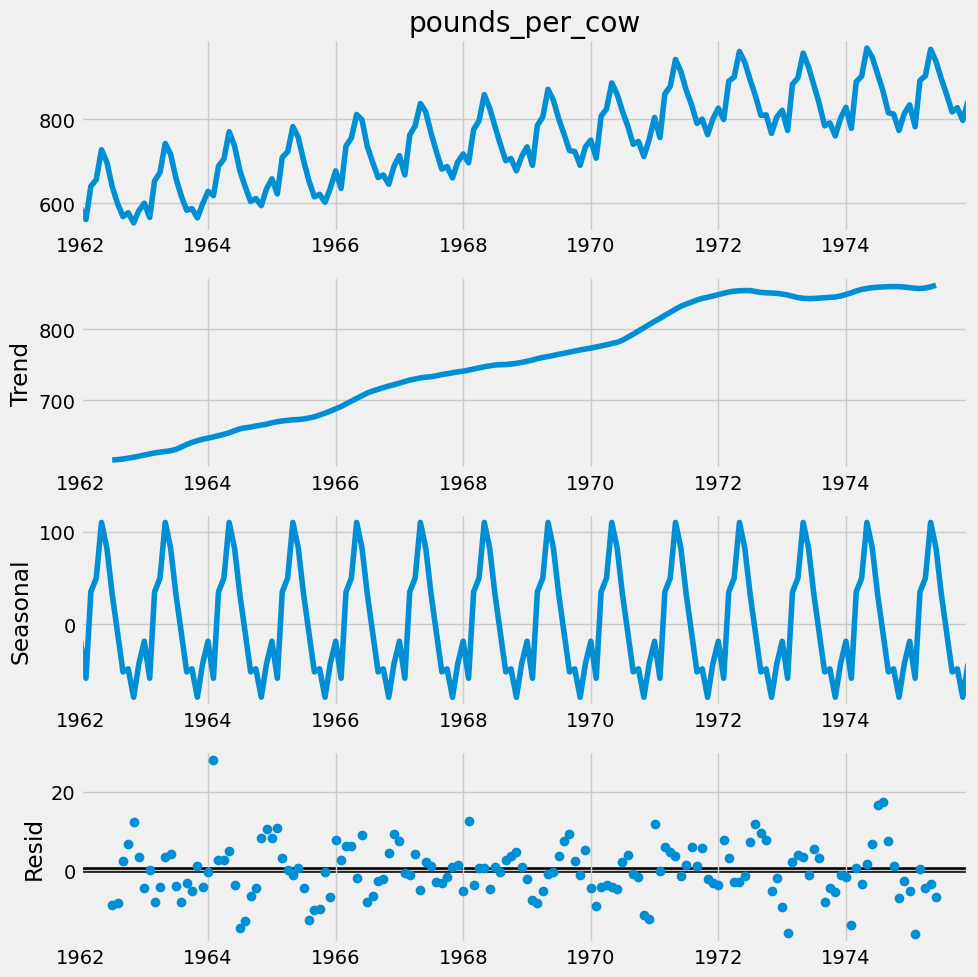

In [97]:
plotSeasonalDecompose(milk_production, 'pounds_per_cow', 12)

### Очистка данных от сезональности и тренда

<AxesSubplot:xlabel='Month'>

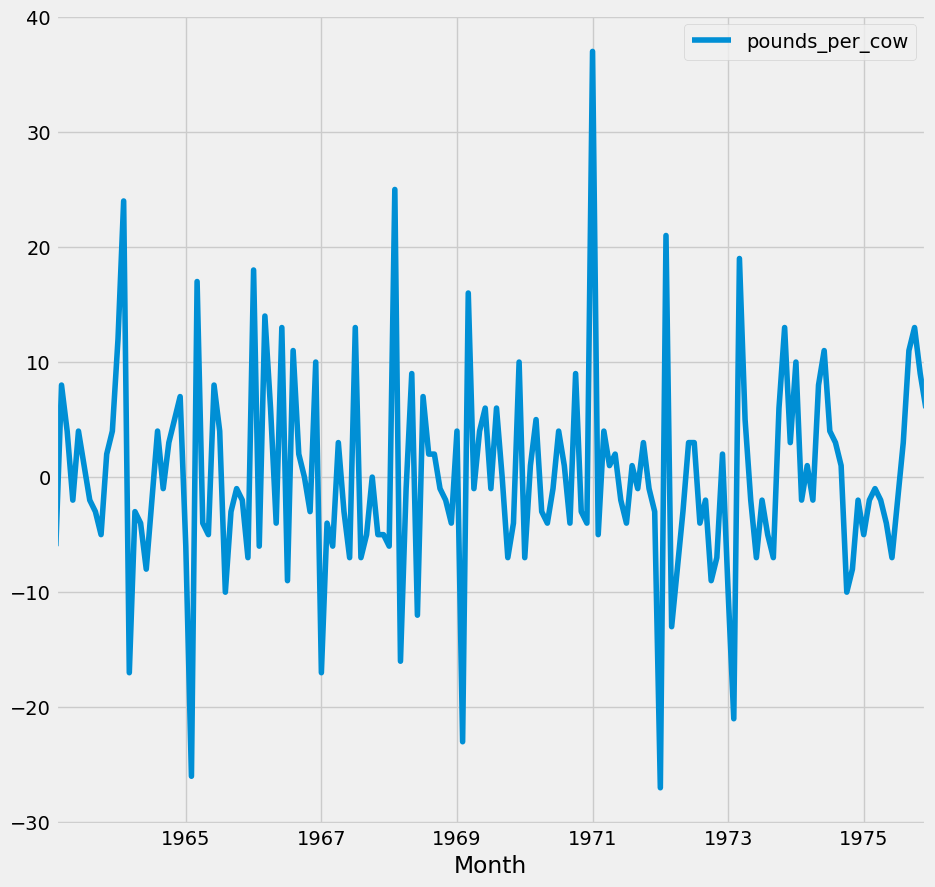

In [100]:
milk_production_diff = dfNormalization(milk_production, 12)
milk_production_diff.plot()

## Подбор параметров auto_arima

### Для не нормализированного набора

In [106]:
model_milk_production = pm.auto_arima(milk_production,
                      seasonal=True, m=24,  # есть ли сезональность, размер сезональности
                      d=1, D=1,             # нужно ли дифференцировать данные (убрать (d)локальный, (D)глобальный тренд)
                      max_p=5, max_q=5,     # сколько вариантов перебирать (от 0 до N)
                      trace=True,           # вывод лога каждой итерации
                      error_action='ignore',
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[24]             : AIC=1006.043, Time=1.39 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=1052.814, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=1001.951, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=1008.765, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=1040.474, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=1003.949, Time=0.50 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=1003.949, Time=0.30 sec
 ARIMA(1,1,0)(0,1,1)[24]             : AIC=1008.503, Time=0.20 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=3.58 sec
 ARIMA(0,1,0)(1,1,0)[24]             : AIC=1007.846, Time=0.10 sec
 ARIMA(2,1,0)(1,1,0)[24]             : AIC=1003.689, Time=0.23 sec
 ARIMA(1,1,1)(1,1,0)[24]             : AIC=1003.831, Time=0.22 sec
 ARIMA(0,1,1)(1,1,0)[24]             : AIC=1002.175, Time=0.14 sec
 ARIMA(2,1,1)(1,1,0)[24]             : AIC=1002.455, Time=0.71 sec
 ARIMA(1,1,0)(1,1,0)[24]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  155
Model:             SARIMAX(3, 1, 0)x(1, 1, 0, 24)   Log Likelihood                -494.500
Date:                            Sun, 23 Oct 2022   AIC                            999.001
Time:                                    01:46:09   BIC                           1013.339
Sample:                                02-01-1963   HQIC                          1004.827
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0154      0.089    -11.418      0.000      -1.190      -0.841
ar.L2         -0.6564      0.130     -5.053      0.000      -0.911      -0.402
ar.L3         -0.1813      0.102     -1.773      0.076      -0.382       0.019
ar.S.L24      -0.6381      0.057    -11.101      0.000      -0.751      -0.525
sigma2       106.1221     10.461     10.144      0.000      85.618     126.626
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                17.36
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.46
Prob(H) (two-sided):                  0.50   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

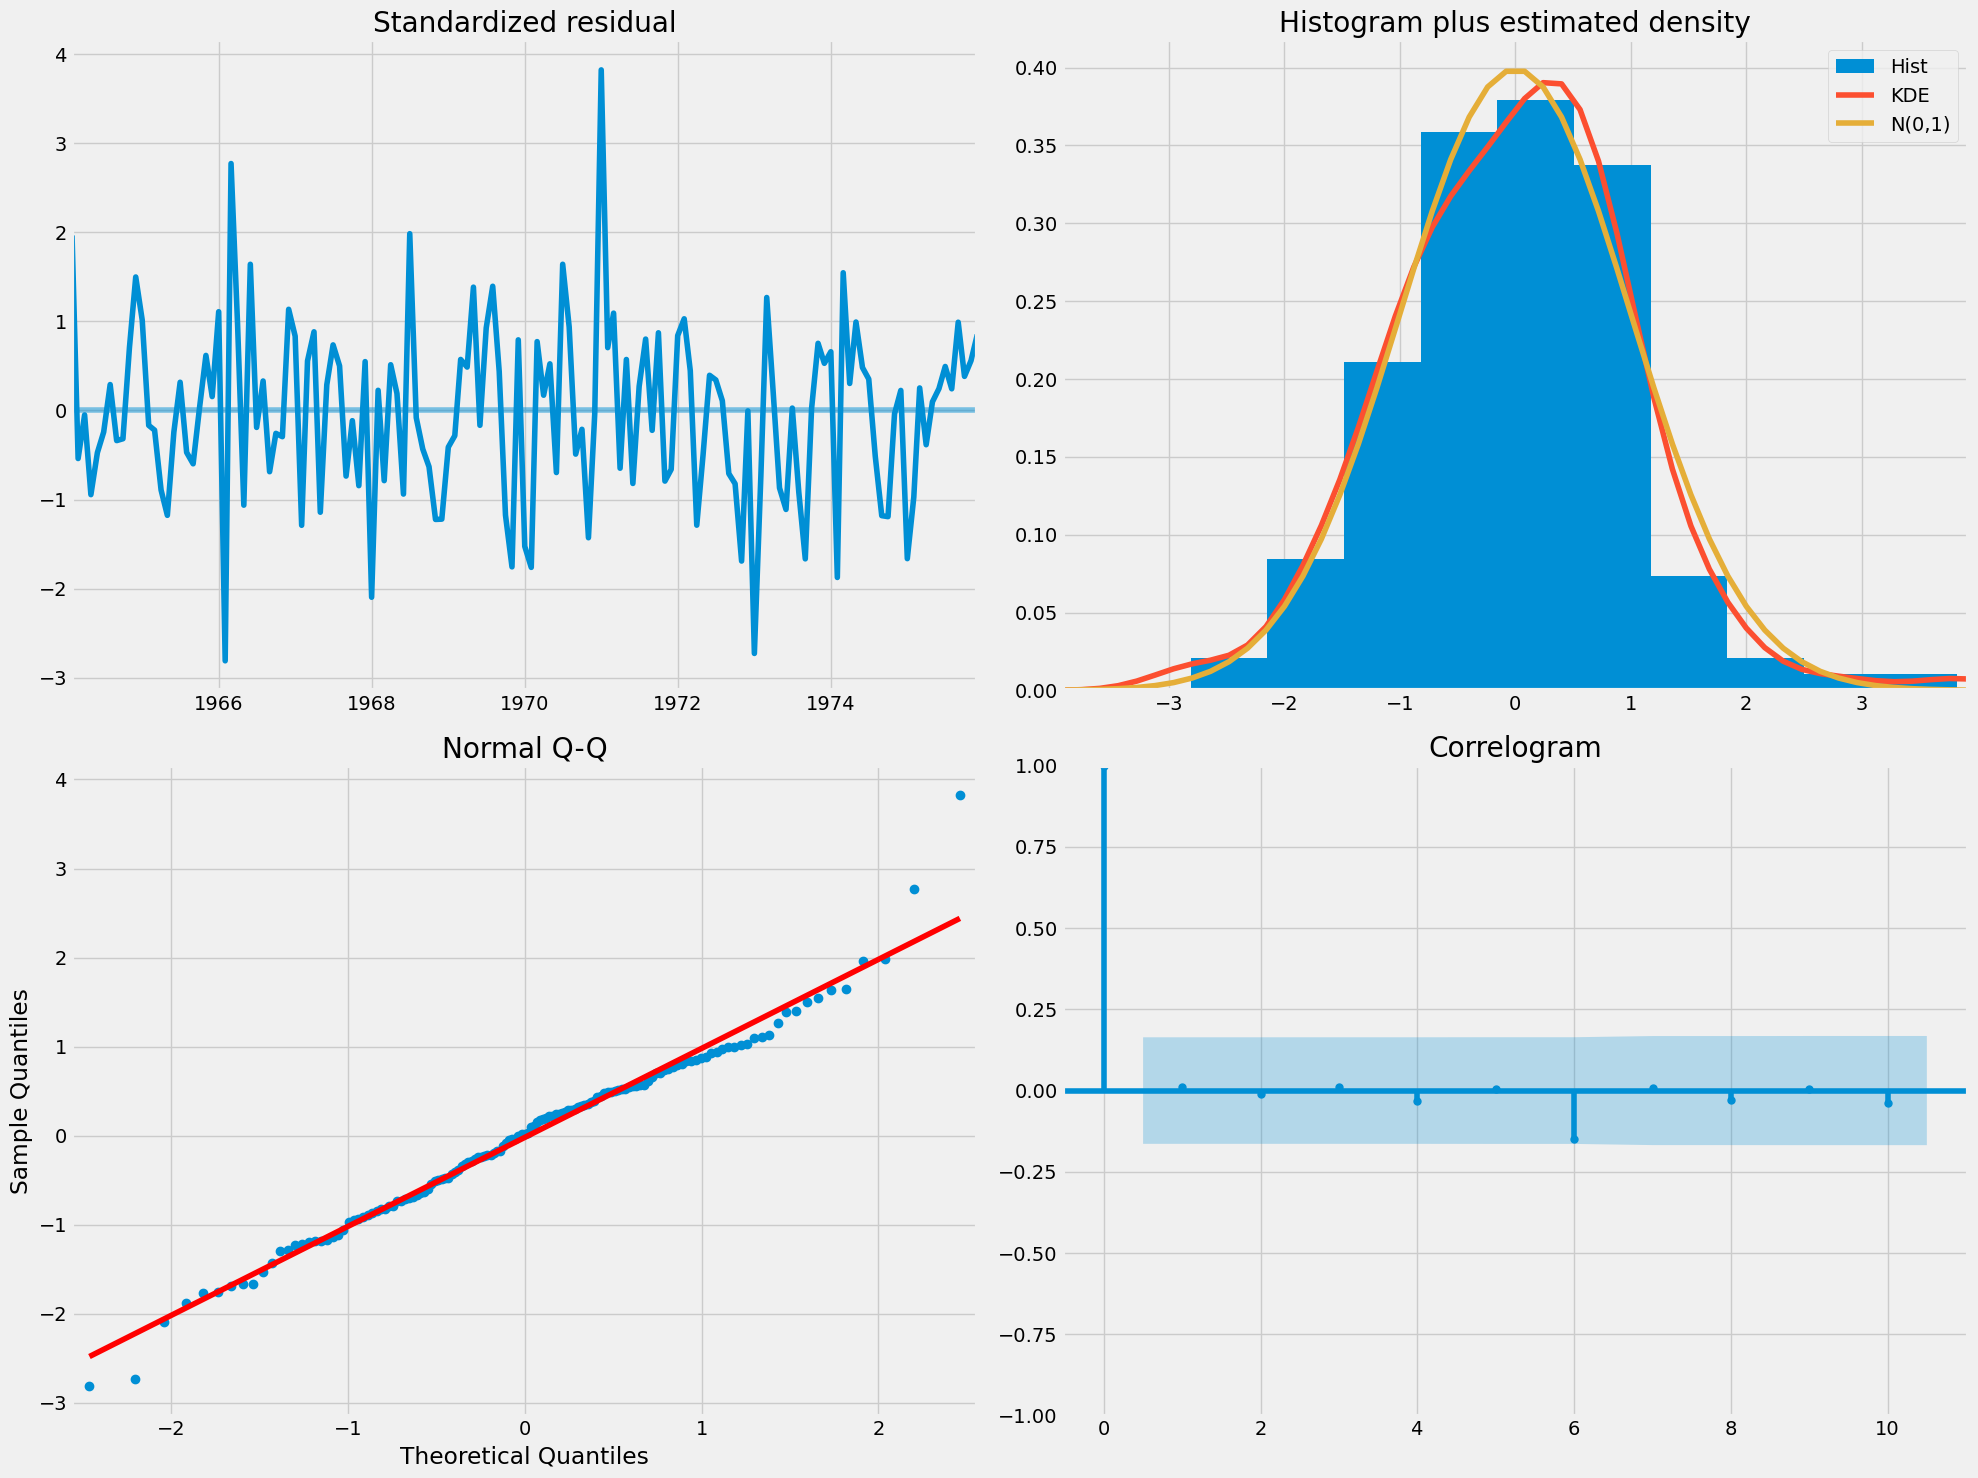

In [200]:
display(model_milk_production.summary())
modelDiagnostics(model_milk_production.fit(milk_production))

### Для нормализированного набора

In [137]:
model_milk_production_diff = pm.auto_arima(milk_production_diff,
                      seasonal=True, m=24,  # есть ли сезональность, размер сезональности
                      d=1, D=1,             # нужно ли дифференцировать данные (убрать (d)локальный, (D)глобальный тренд)
                      max_p=5, max_q=5,     # сколько вариантов перебирать (от 0 до N)
                      trace=True,           # вывод лога каждой итерации
                      error_action='ignore',
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[24]             : AIC=inf, Time=2.03 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=1167.249, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=1034.936, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=0.47 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=1101.383, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=1035.209, Time=0.55 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=1029.955, Time=0.51 sec
 ARIMA(1,1,0)(0,1,1)[24]             : AIC=inf, Time=0.49 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=2.90 sec
 ARIMA(1,1,0)(1,1,2)[24]             : AIC=inf, Time=3.53 sec
 ARIMA(1,1,0)(0,1,2)[24]             : AIC=1031.320, Time=1.10 sec
 ARIMA(1,1,0)(2,1,2)[24]             : AIC=inf, Time=3.82 sec
 ARIMA(0,1,0)(1,1,1)[24]             : AIC=inf, Time=0.60 sec
 ARIMA(2,1,0)(1,1,1)[24]             : AIC=1002.055, Time=0.58 sec
 ARIMA(2,1,0)(0,1,1)[24]             : AIC=inf, Time=0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  155
Model:             SARIMAX(3, 1, 0)x(1, 1, 0, 24)   Log Likelihood                -494.500
Date:                            Sun, 23 Oct 2022   AIC                            999.001
Time:                                    01:46:23   BIC                           1013.339
Sample:                                02-01-1963   HQIC                          1004.827
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0154      0.089    -11.418      0.000      -1.190      -0.841
ar.L2         -0.6564      0.130     -5.053      0.000      -0.911      -0.402
ar.L3         -0.1813      0.102     -1.773      0.076      -0.382       0.019
ar.S.L24      -0.6381      0.057    -11.101      0.000      -0.751      -0.525
sigma2       106.1221     10.461     10.144      0.000      85.618     126.626
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                17.36
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.46
Prob(H) (two-sided):                  0.50   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

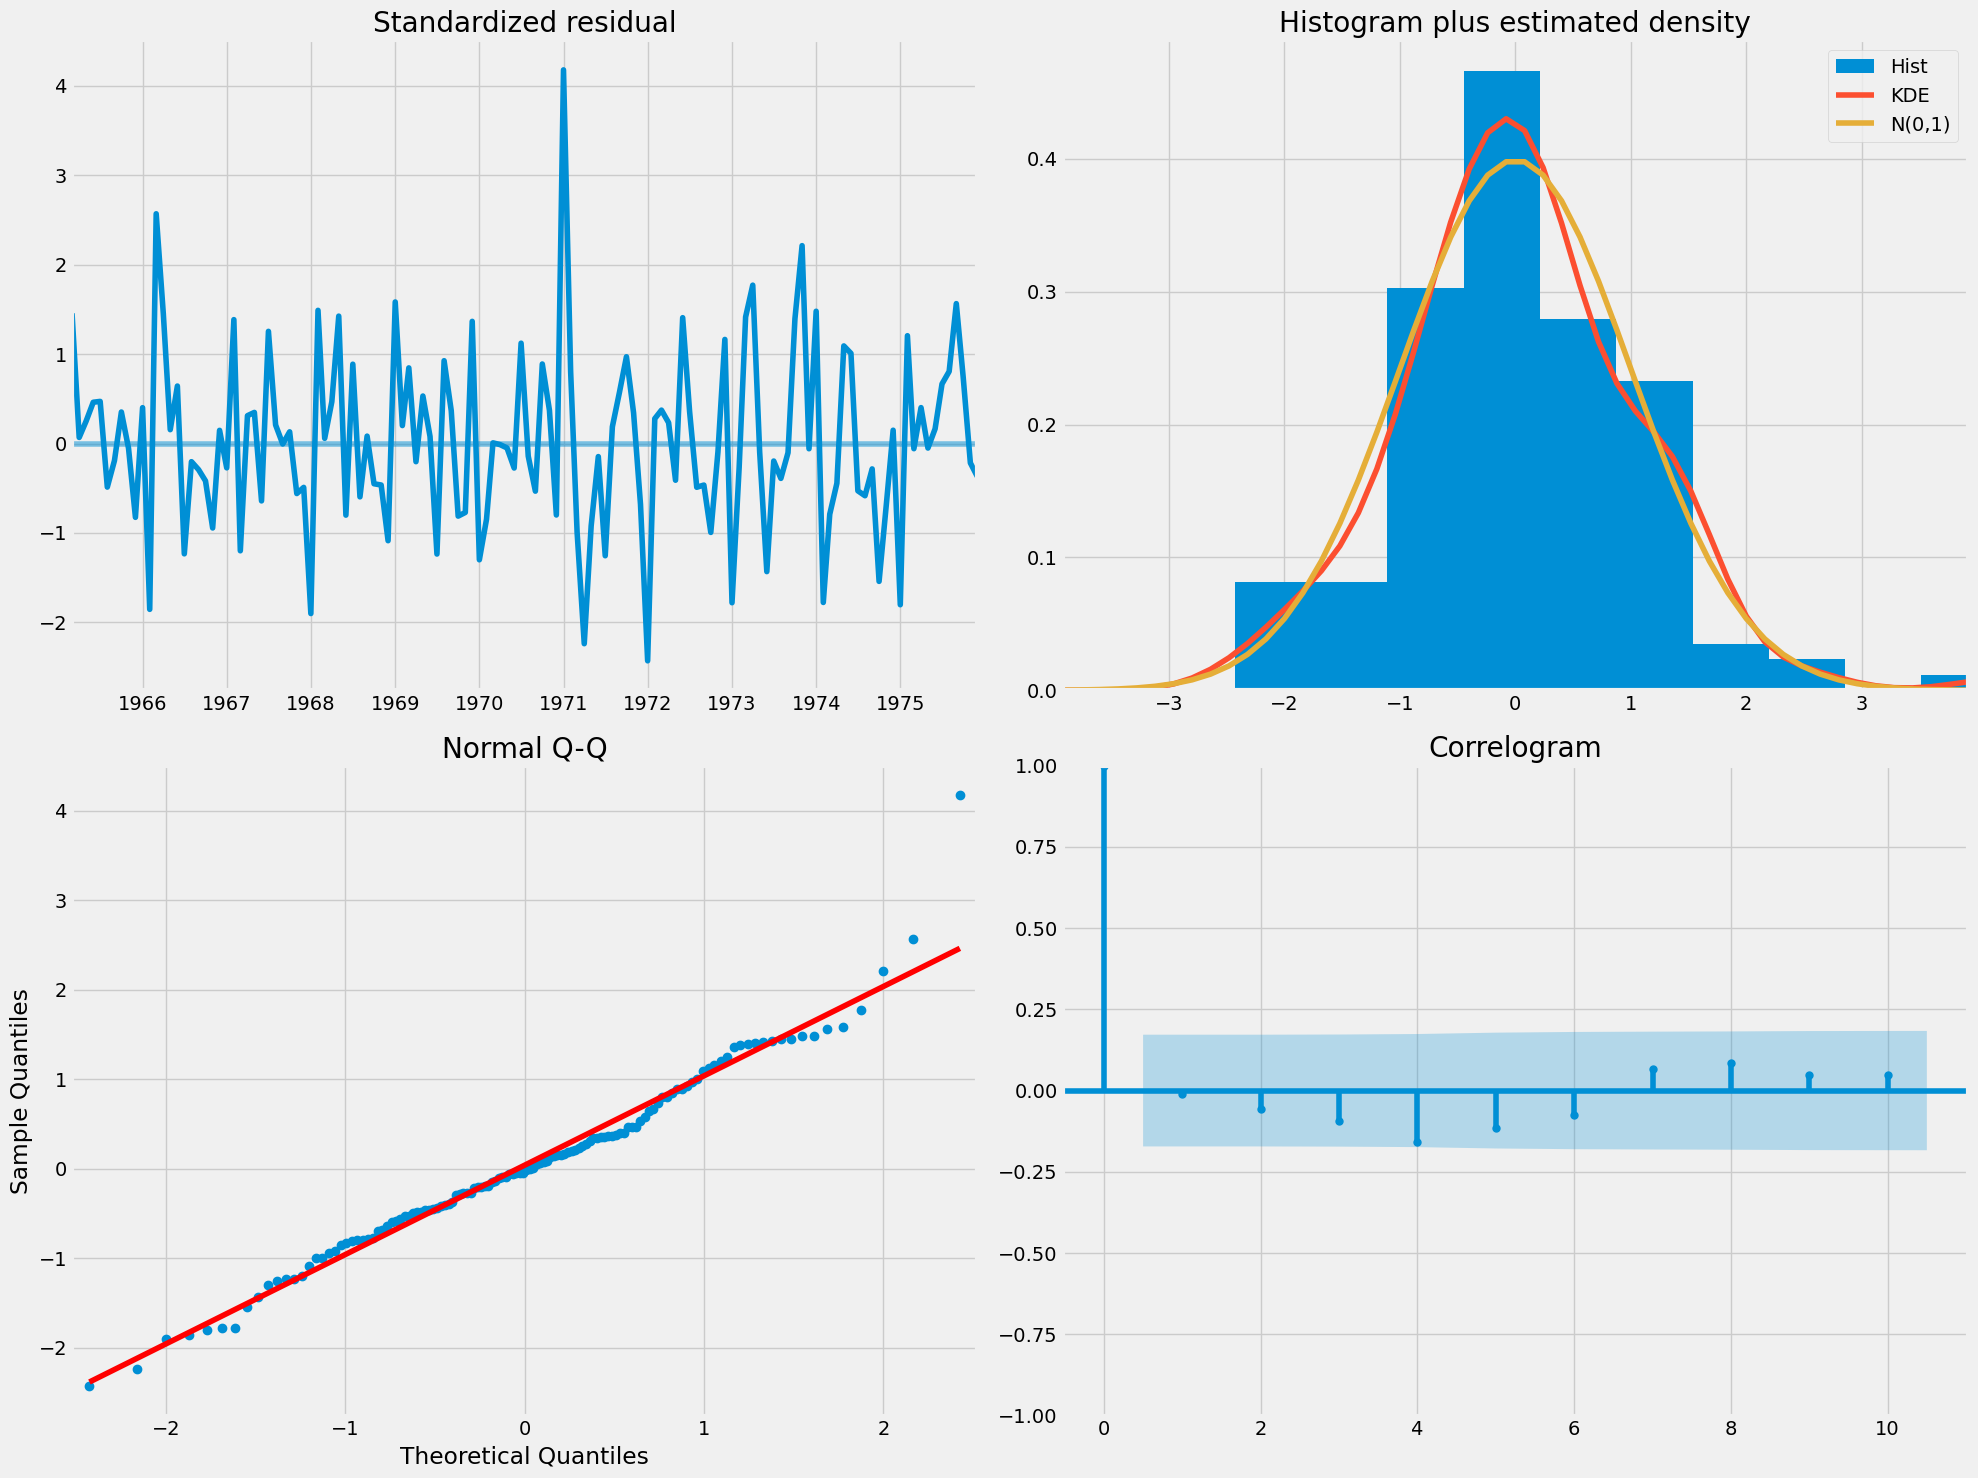

In [201]:
display(model_milk_production_diff.summary())
modelDiagnostics(model_milk_production_diff.fit(milk_production_diff))

## Добавим день недели 

### Для не нормализованного набора

c:\Users\leysh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\leysh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     pounds_per_cow   No. Observations:                  168
Model:             SARIMAX(3, 1, 0)x(1, 1, 0, 24)   Log Likelihood                -496.424
Date:                            Sun, 23 Oct 2022   AIC                           1004.849
Time:                                    01:48:14   BIC                           1022.626
Sample:                                01-01-1962   HQIC                          1012.072
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0379      0.181     -0.209      0.834      -0.393       0.318
ar.L1         -0.2392      0.084     -2.847      0.004      -0.404      -0.075
ar.L2         -0.0073      0.088     -0.083      0.934      -0.181       0.166
ar.L3          0.1422      0.093      1.531      0.126      -0.040       0.324
ar.S.L24      -0.5075      0.057     -8.896      0.000      -0.619      -0.396
sigma2        57.6485      6.417      8.983      0.000      45.071      70.226
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 8.48
Prob(Q):                              0.89   Prob(JB):                         0.01
Heteroskedasticity (H):               0.87   Skew:                             0.17
Prob(H) (two-sided):                  0.62   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

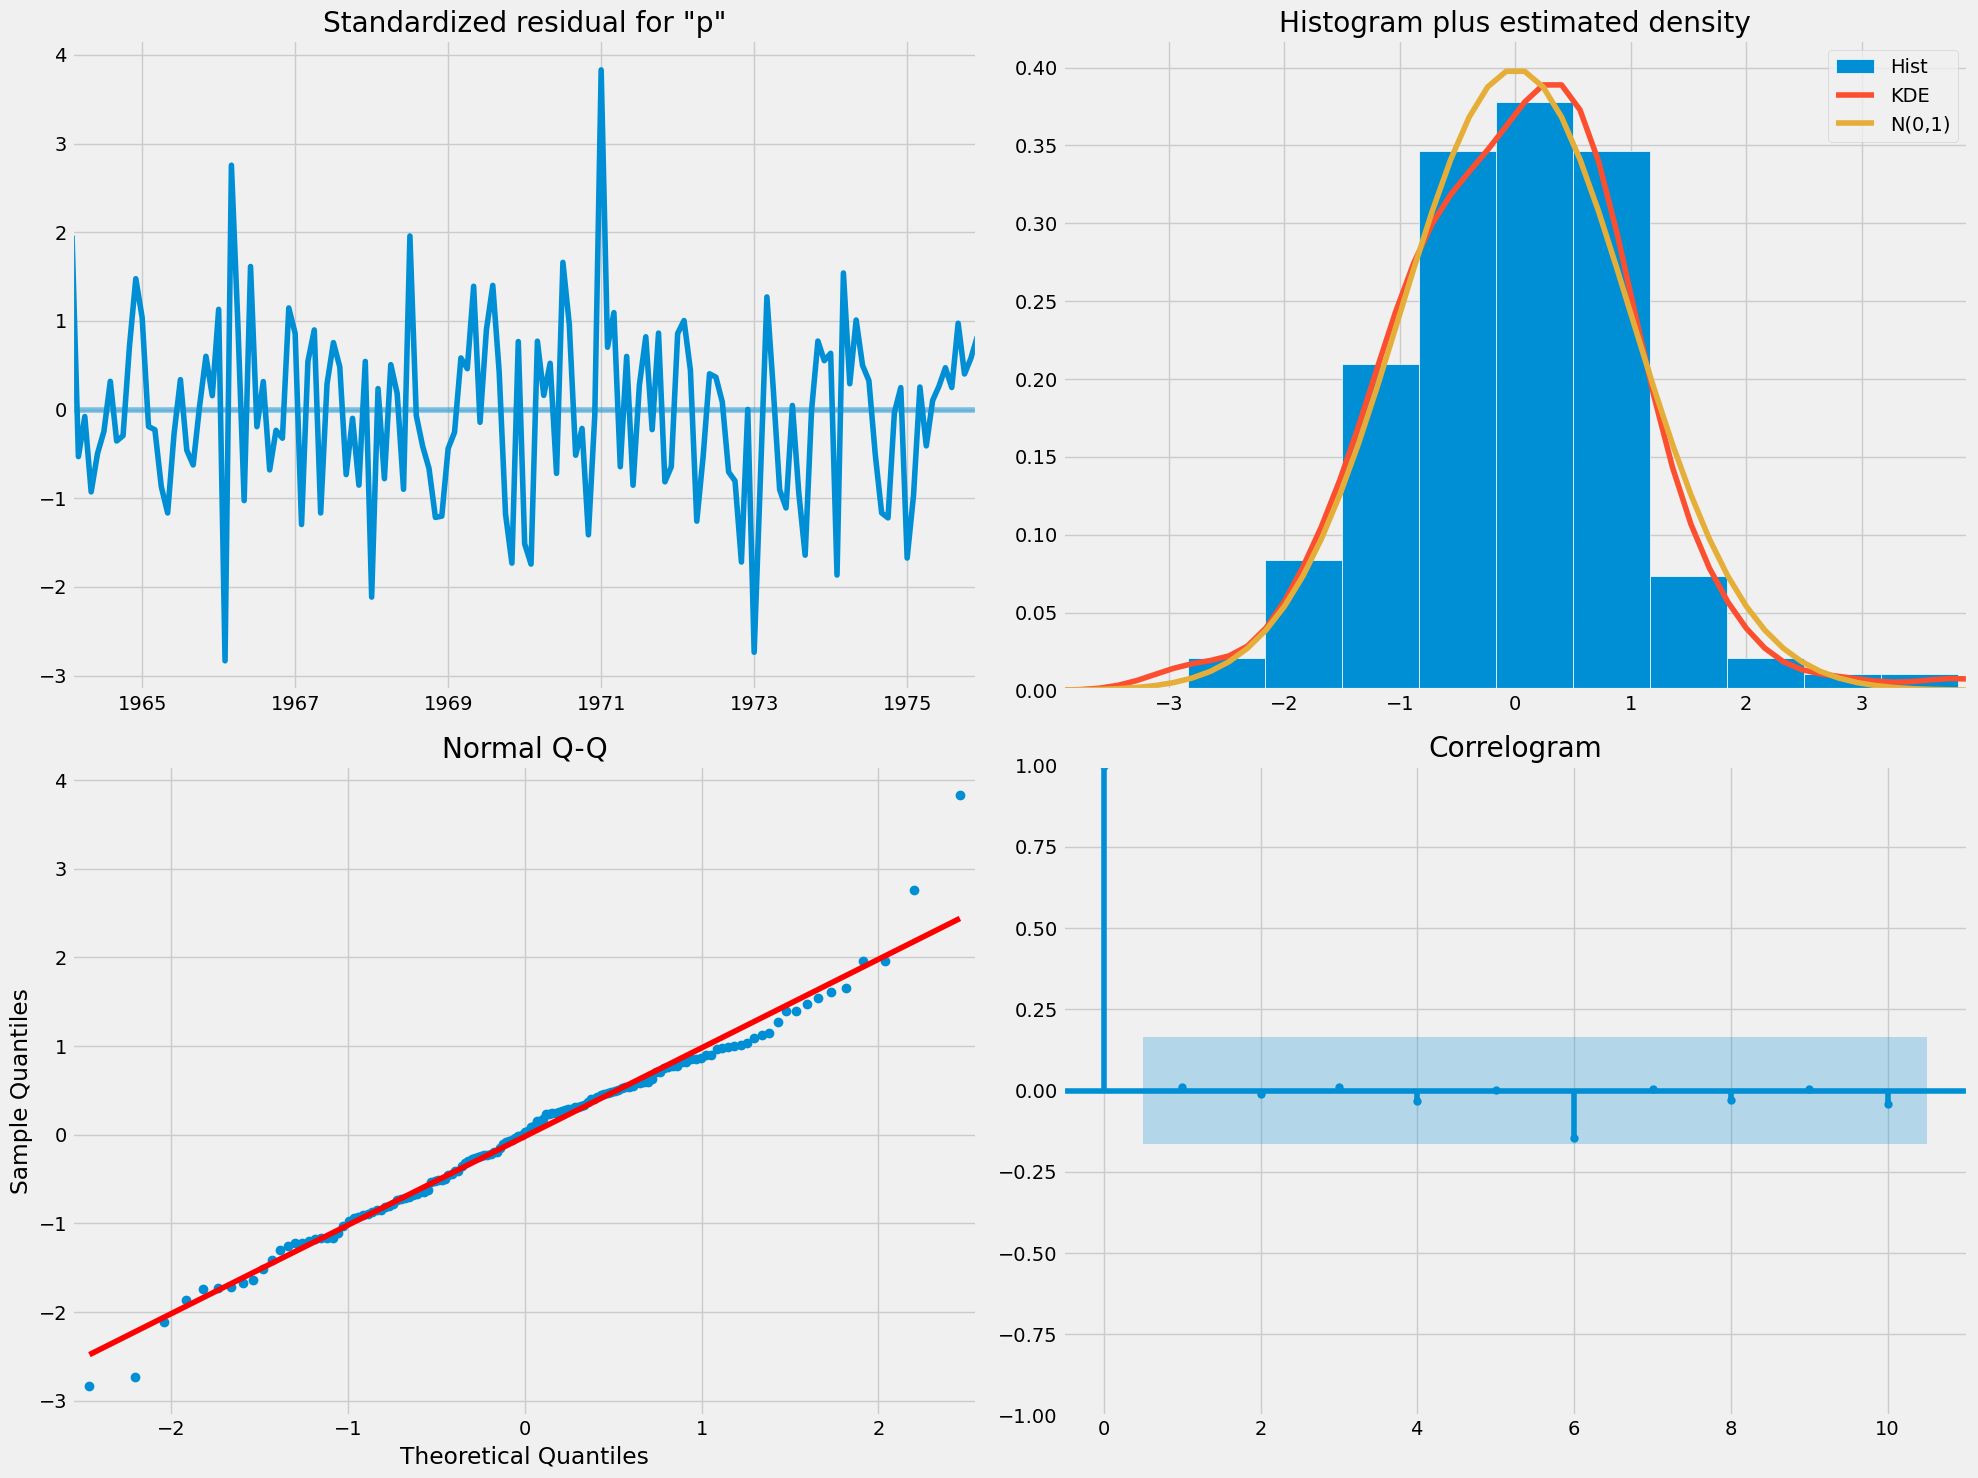

In [203]:
createModelSARIMAXex(model_milk_production, milk_production)

### Для нормализованного набора

c:\Users\leysh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\leysh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     pounds_per_cow   No. Observations:                  155
Model:             SARIMAX(3, 1, 0)x(1, 1, 0, 24)   Log Likelihood                -494.493
Date:                            Sun, 23 Oct 2022   AIC                           1000.986
Time:                                    01:48:13   BIC                           1018.191
Sample:                                02-01-1963   HQIC                          1007.977
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0386      0.357     -0.108      0.914      -0.739       0.662
ar.L1         -1.0158      0.089    -11.381      0.000      -1.191      -0.841
ar.L2         -0.6563      0.131     -5.018      0.000      -0.913      -0.400
ar.L3         -0.1816      0.103     -1.762      0.078      -0.384       0.020
ar.S.L24      -0.6387      0.058    -11.061      0.000      -0.752      -0.526
sigma2       106.0866     10.694      9.920      0.000      85.126     127.047
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                17.03
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.46
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

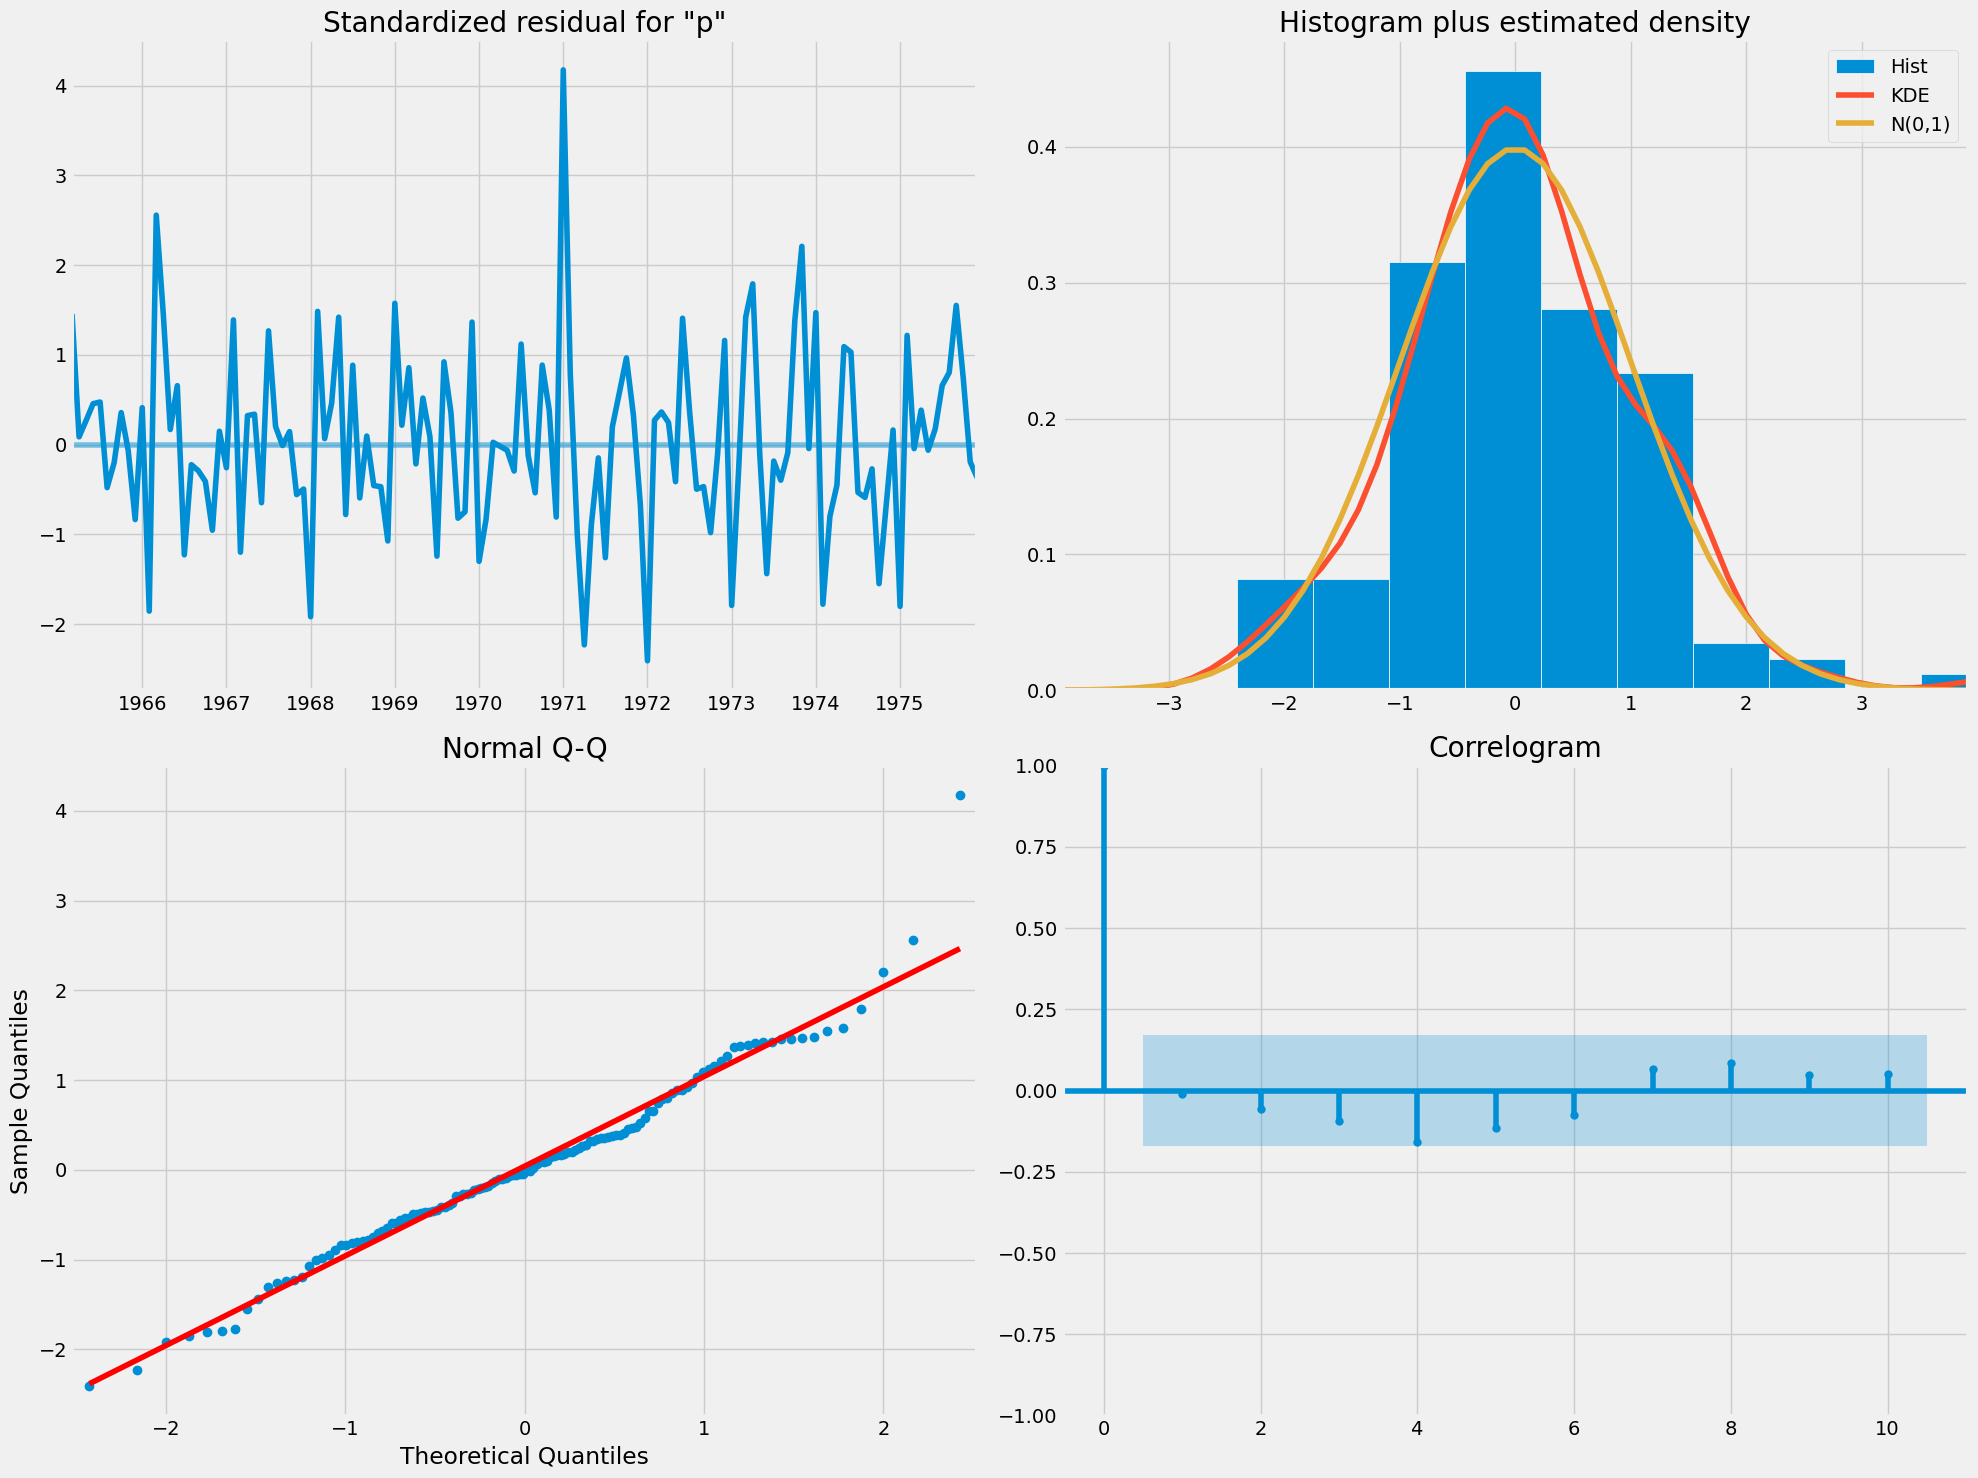

In [202]:
createModelSARIMAXex(model_milk_production_diff, milk_production_diff)

## Вывод 
Добавление дней недели ухудшает точность моделей

# Dataset AirPassengers

## Загрузка данных 

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

[144 rows x 1 columns]

<AxesSubplot:xlabel='Month'>

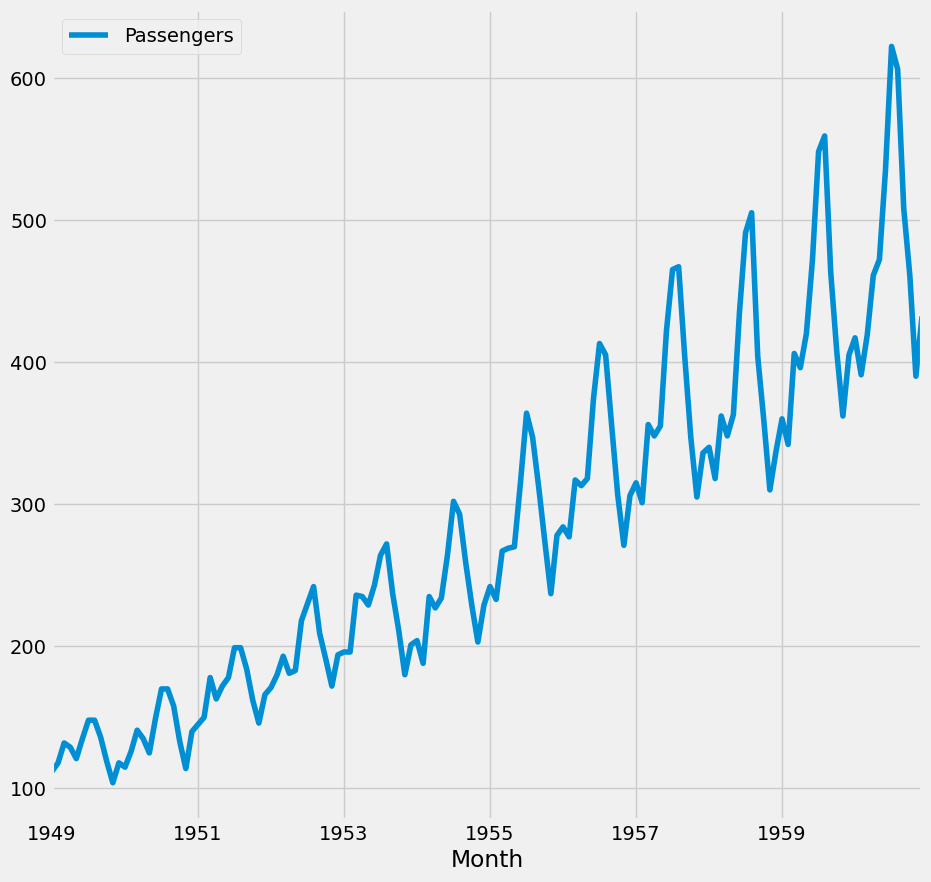

In [37]:
AirPassengers = pd.read_csv('data/AirPassengers.csv', index_col=0, parse_dates=True)
AirPassengers.columns = ['Passengers']
display(AirPassengers)
AirPassengers.plot()

### Декомпозиция сезонности

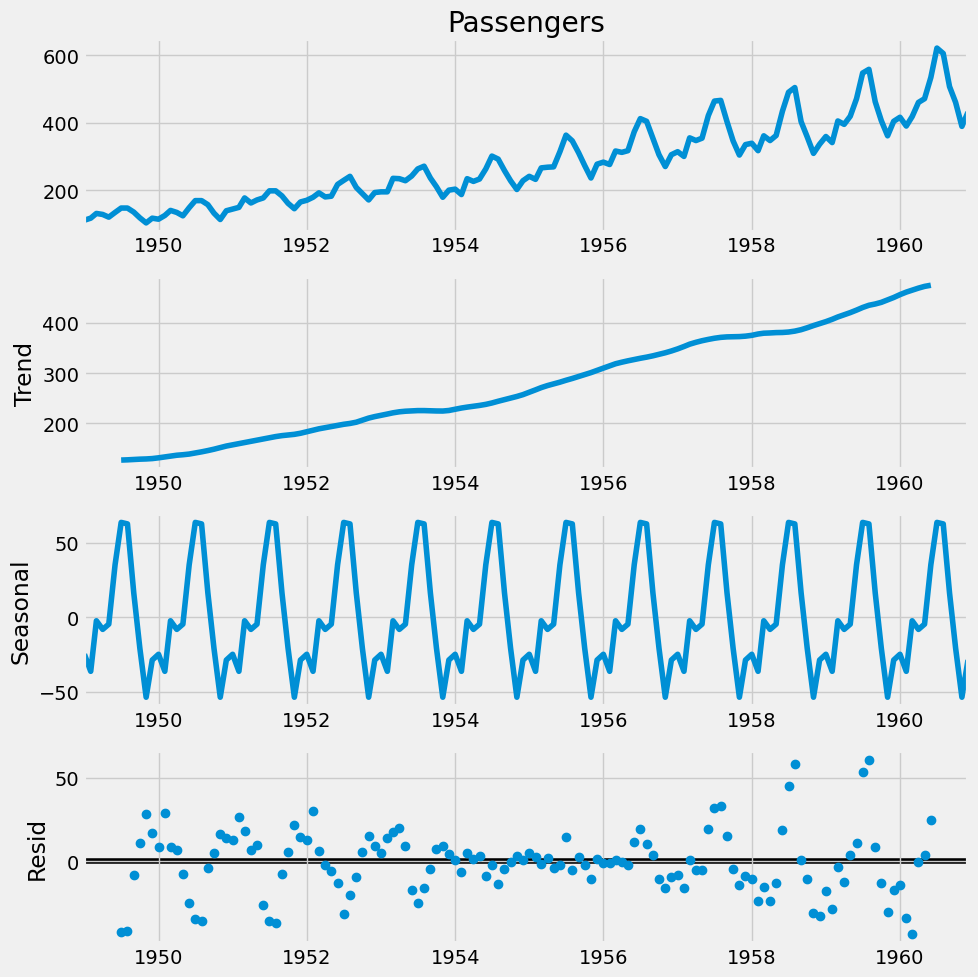

In [101]:
plotSeasonalDecompose(AirPassengers, 'Passengers', 12)

### Очистка данных от сезональности и тренда

<AxesSubplot:xlabel='Month'>

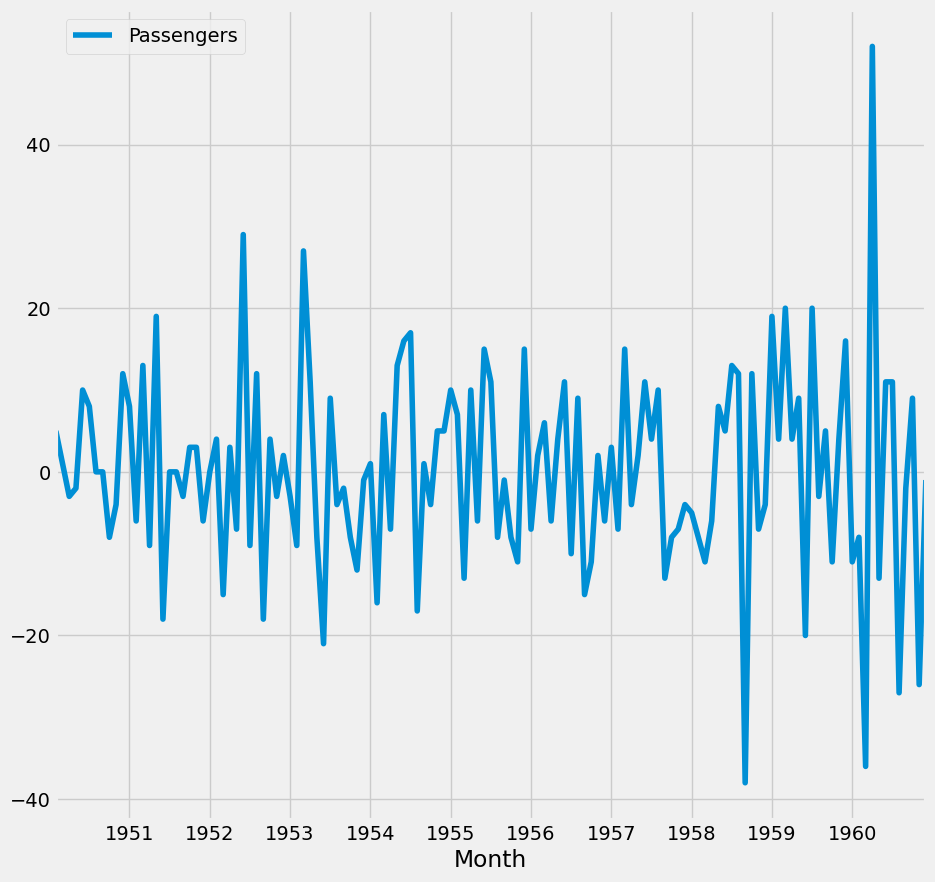

In [102]:
AirPassengers_diff = dfNormalization(AirPassengers, 12)
AirPassengers_diff.plot()

## Подбор параметров auto_arima

### Для не нормализированного набора

In [141]:
model_AirPassengers = pm.auto_arima(AirPassengers,
                      seasonal=True, m=24,  # есть ли сезональность, размер сезональности
                      d=1, D=1,             # нужно ли дифференцировать данные (убрать (d)локальный, (D)глобальный тренд)
                      max_p=5, max_q=5,     # сколько вариантов перебирать (от 0 до N)
                      trace=True,           # вывод лога каждой итерации
                      error_action='ignore',
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[24]             : AIC=inf, Time=2.47 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=988.856, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=984.083, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=984.697, Time=0.27 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=984.234, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=979.750, Time=0.53 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=3.43 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(2,1,0)[24]             : AIC=989.803, Time=0.43 sec
 ARIMA(2,1,0)(2,1,0)[24]             : AIC=980.107, Time=0.82 sec
 ARIMA(1,1,1)(2,1,0)[24]             : AIC=978.716, Time=1.18 sec
 ARIMA(1,1,1)(1,1,0)[24]             : AIC=985.824, Time=0.26 sec
 ARIMA(1,1,1)(2,1,1)[24]             : AIC=inf, Time=4.30 sec
 ARIMA(1,1,1)(1,1,1)[24]             : AIC=inf, Time=2.11 sec
 ARIMA(0,1,1)(2,1,0)[24]             : AIC=977.907, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 24)   Log Likelihood                -484.954
Date:                             Sun, 23 Oct 2022   AIC                            977.907
Time:                                     01:45:44   BIC                            989.024
Sample:                                 01-01-1949   HQIC                           982.421
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4107      0.066     -6.206      0.000      -0.540      -0.281
ar.S.L24       0.1241      0.101      1.225      0.221      -0.074       0.323
ar.S.L48       0.3434      0.126      2.729      0.006       0.097       0.590
sigma2       191.1654     20.488      9.330      0.000     151.009     231.322
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                10.25
Prob(Q):                              0.97   Prob(JB):                         0.01
Heteroskedasticity (H):               2.92   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

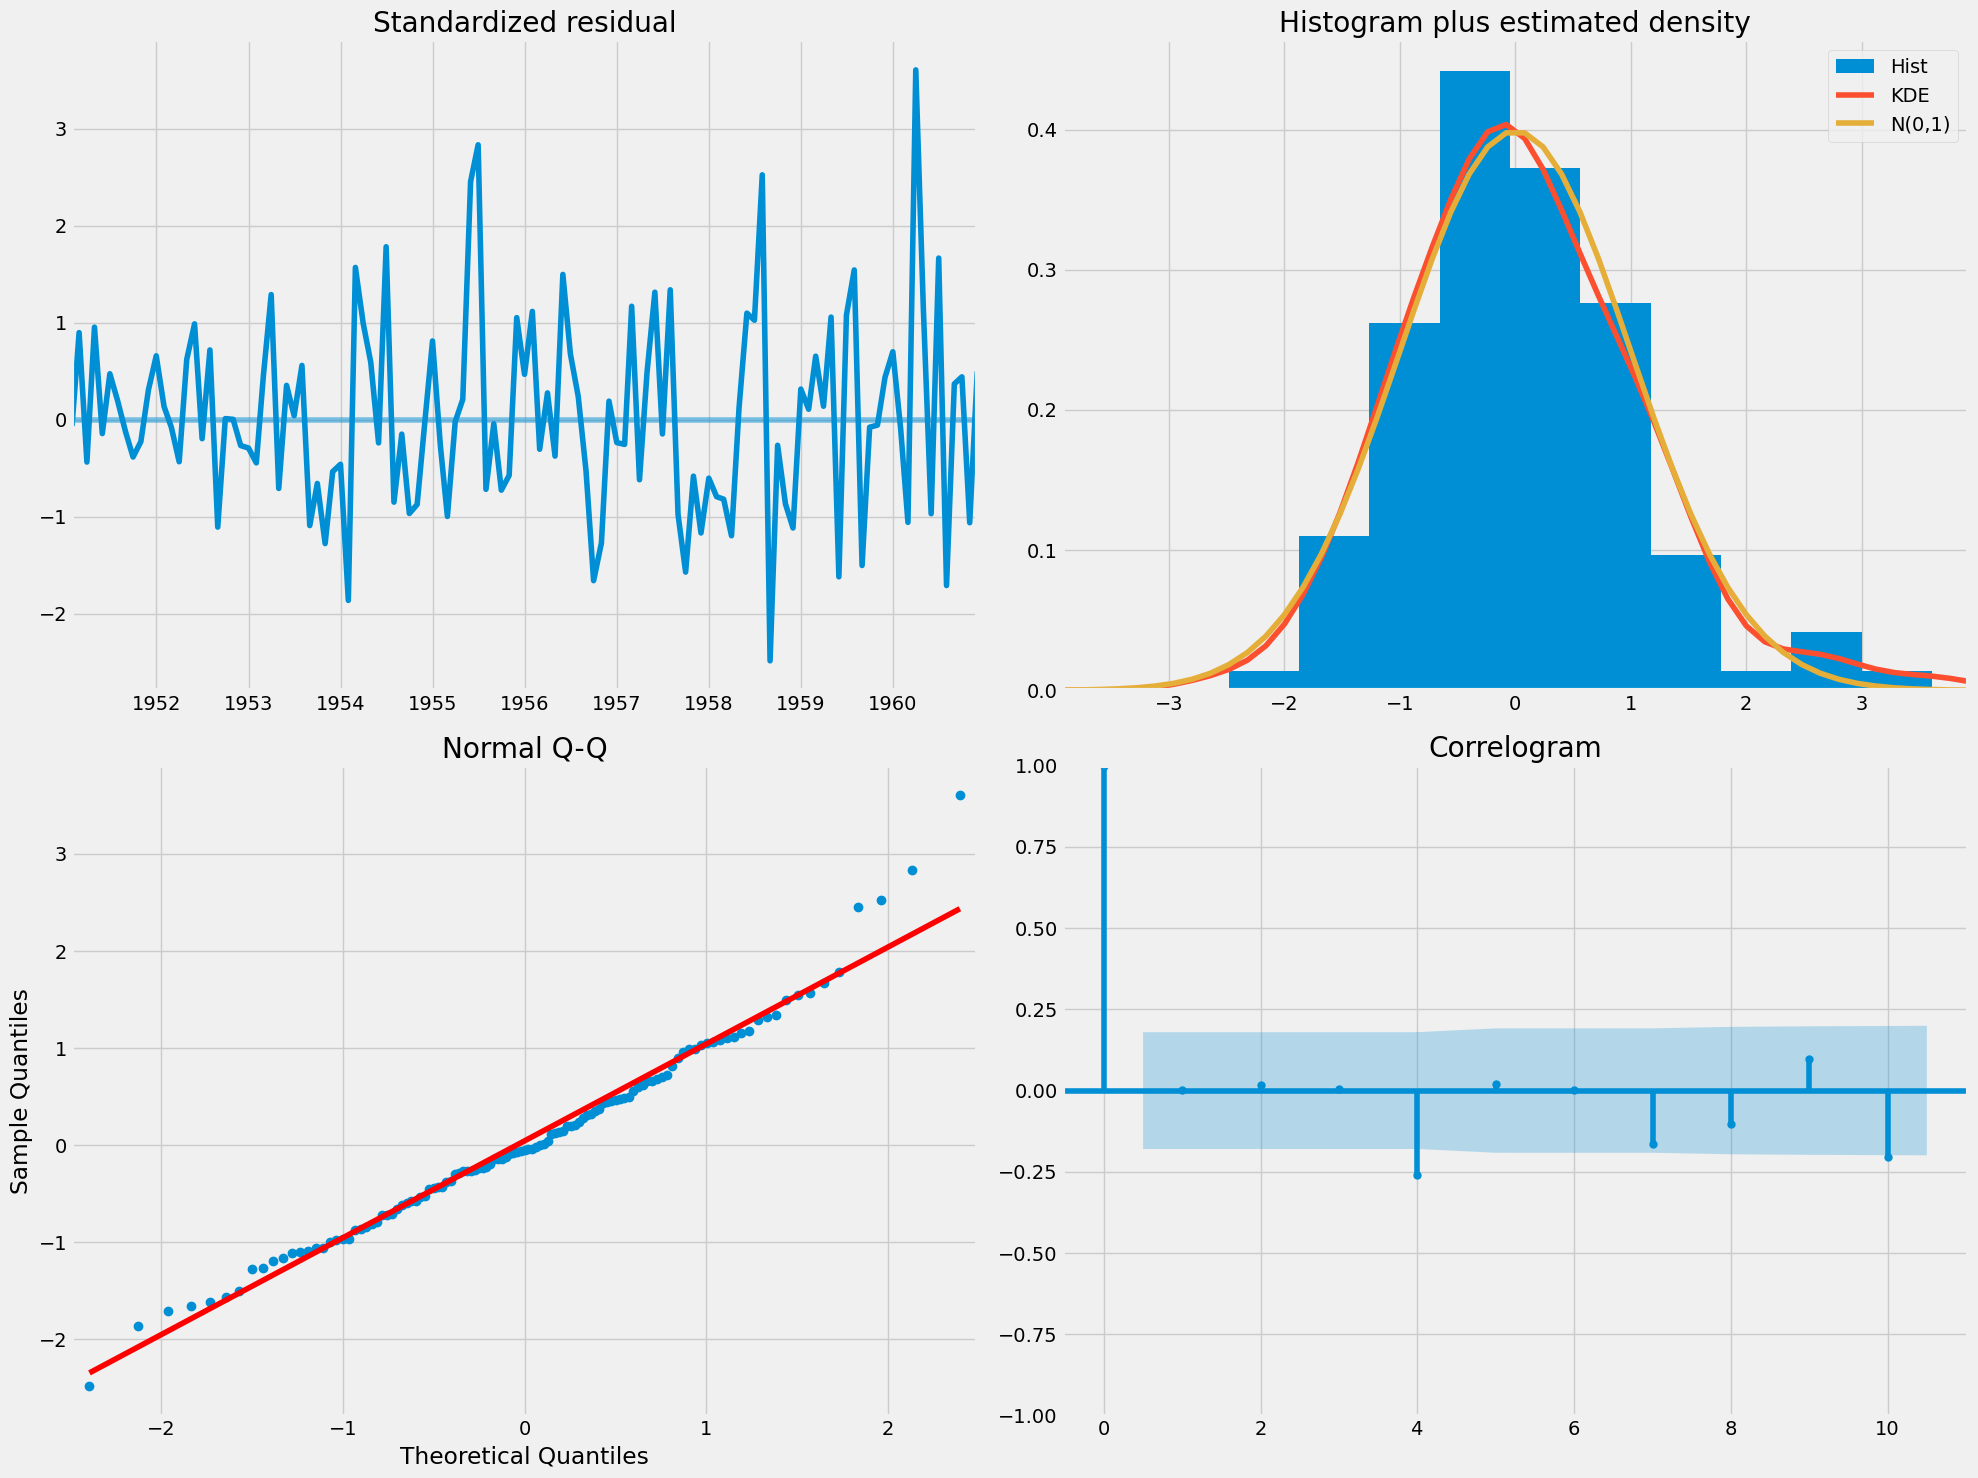

In [199]:
display(model_AirPassengers.summary())
modelDiagnostics(model_AirPassengers.fit(AirPassengers))

### Для нормализированного набора

In [150]:
model_AirPassengers_diff = pm.auto_arima(AirPassengers_diff,
                      seasonal=True, m=24,  # есть ли сезональность, размер сезональности
                      d=1, D=1,             # нужно ли дифференцировать данные (убрать (d)локальный, (D)глобальный тренд)
                      max_p=5, max_q=5,     # сколько вариантов перебирать (от 0 до N)
                      trace=True,           # вывод лога каждой итерации
                      error_action='ignore',
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[24]             : AIC=inf, Time=1.18 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=1006.123, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=924.336, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=936.380, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=913.924, Time=0.52 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=915.700, Time=1.26 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=916.807, Time=0.47 sec
 ARIMA(0,1,0)(2,1,0)[24]             : AIC=983.941, Time=0.37 sec
 ARIMA(2,1,0)(2,1,0)[24]             : AIC=890.357, Time=0.74 sec
 ARIMA(2,1,0)(1,1,0)[24]             : AIC=899.894, Time=0.25 sec
 ARIMA(2,1,0)(2,1,1)[24]             : AIC=891.652, Time=1.49 sec
 ARIMA(2,1,0)(1,1,1)[24]             : AIC=891.973, Time=0.74 sec
 ARIMA(3,1,0)(2,1,0)[24]             : AIC=886.756, Time=0.89 sec
 ARIMA(3,1,0)(1,1,0)[24]             : A

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  131
Model:             SARIMAX(5, 1, 0)x(2, 1, 0, 24)   Log Likelihood                -425.431
Date:                            Sun, 23 Oct 2022   AIC                            866.863
Time:                                    01:45:20   BIC                            888.170
Sample:                                02-01-1950   HQIC                           875.499
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3210      0.082    -16.178      0.000      -1.481      -1.161
ar.L2         -1.1338      0.118     -9.602      0.000      -1.365      -0.902
ar.L3         -0.9150      0.160     -5.726      0.000      -1.228      -0.602
ar.L4         -0.7402      0.168     -4.417      0.000      -1.069      -0.412
ar.L5         -0.3343      0.115     -2.909      0.004      -0.559      -0.109
ar.S.L24      -0.7068      0.099     -7.143      0.000      -0.901      -0.513
ar.S.L48      -0.4478      0.116     -3.852      0.000      -0.676      -0.220
sigma2       148.9803     19.615      7.595      0.000     110.536     187.425
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 8.95
Prob(Q):                              0.61   Prob(JB):                         0.01
Heteroskedasticity (H):               2.43   Skew:                             0.10
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

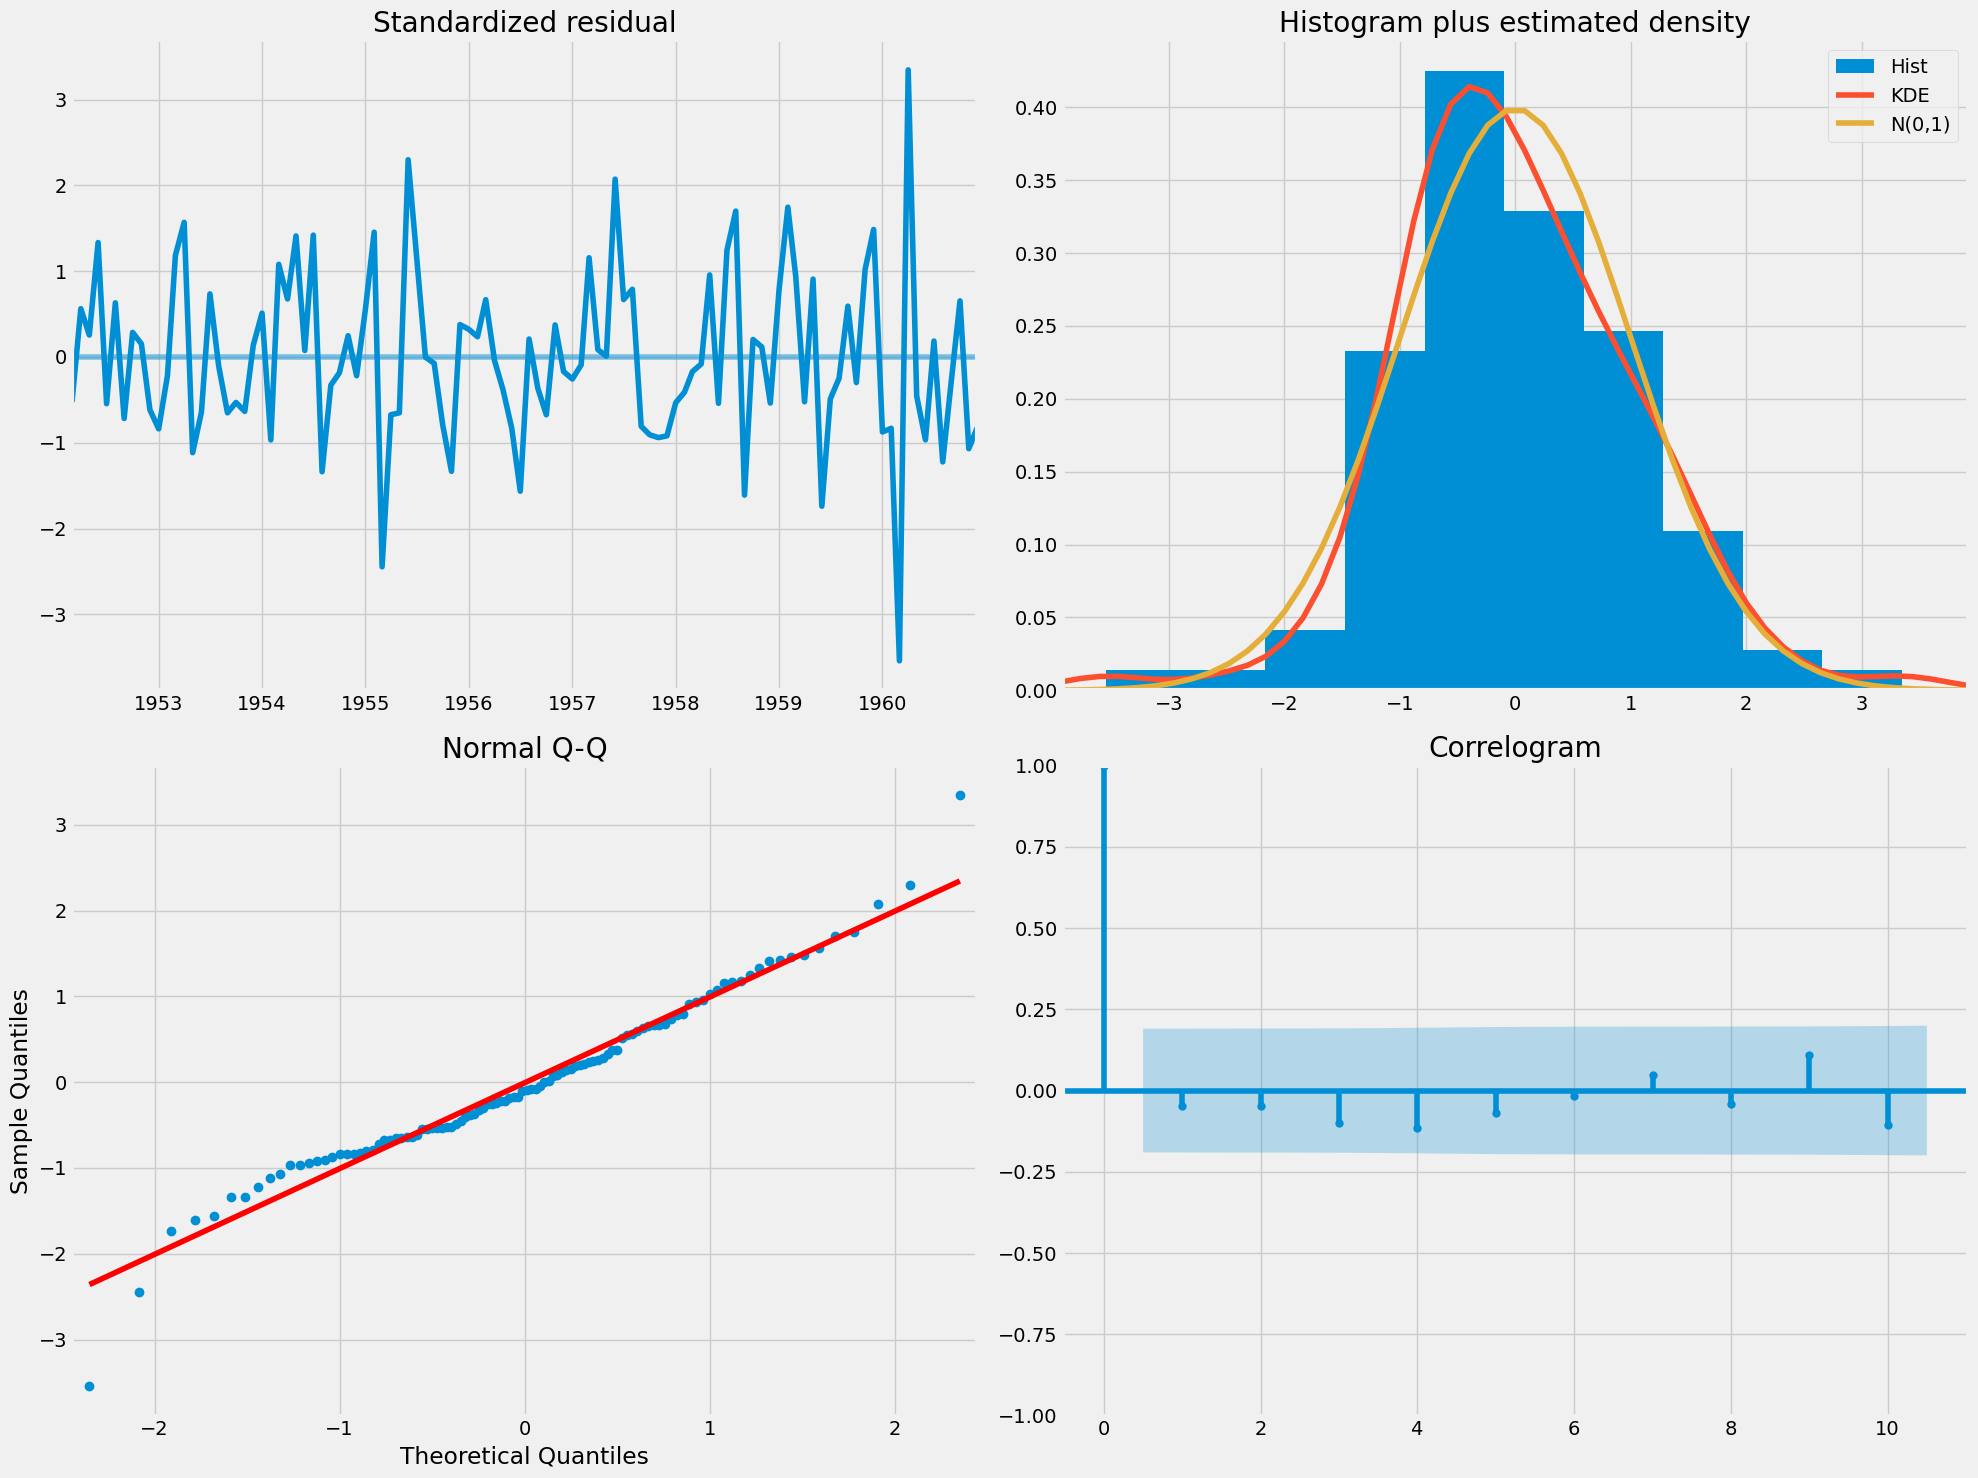

In [198]:
display(model_AirPassengers_diff.summary())
modelDiagnostics(model_AirPassengers_diff.fit(AirPassengers_diff))

## Добавим день недели 

### Для не нормализованного набора

c:\Users\leysh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\leysh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          Passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 24)   Log Likelihood                -475.040
Date:                             Sun, 23 Oct 2022   AIC                            960.079
Time:                                     01:48:42   BIC                            973.975
Sample:                                 01-01-1949   HQIC                           965.722
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0715      0.261      4.102      0.000       0.560       1.583
ma.L1         -0.3275      0.071     -4.600      0.000      -0.467      -0.188
ar.S.L24       0.1623      0.102      1.587      0.113      -0.038       0.363
ar.S.L48       0.3528      0.128      2.764      0.006       0.103       0.603
sigma2       160.5102     18.853      8.514      0.000     123.559     197.461
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.23
Prob(Q):                              0.97   Prob(JB):                         0.01
Heteroskedasticity (H):               1.83   Skew:                             0.58
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

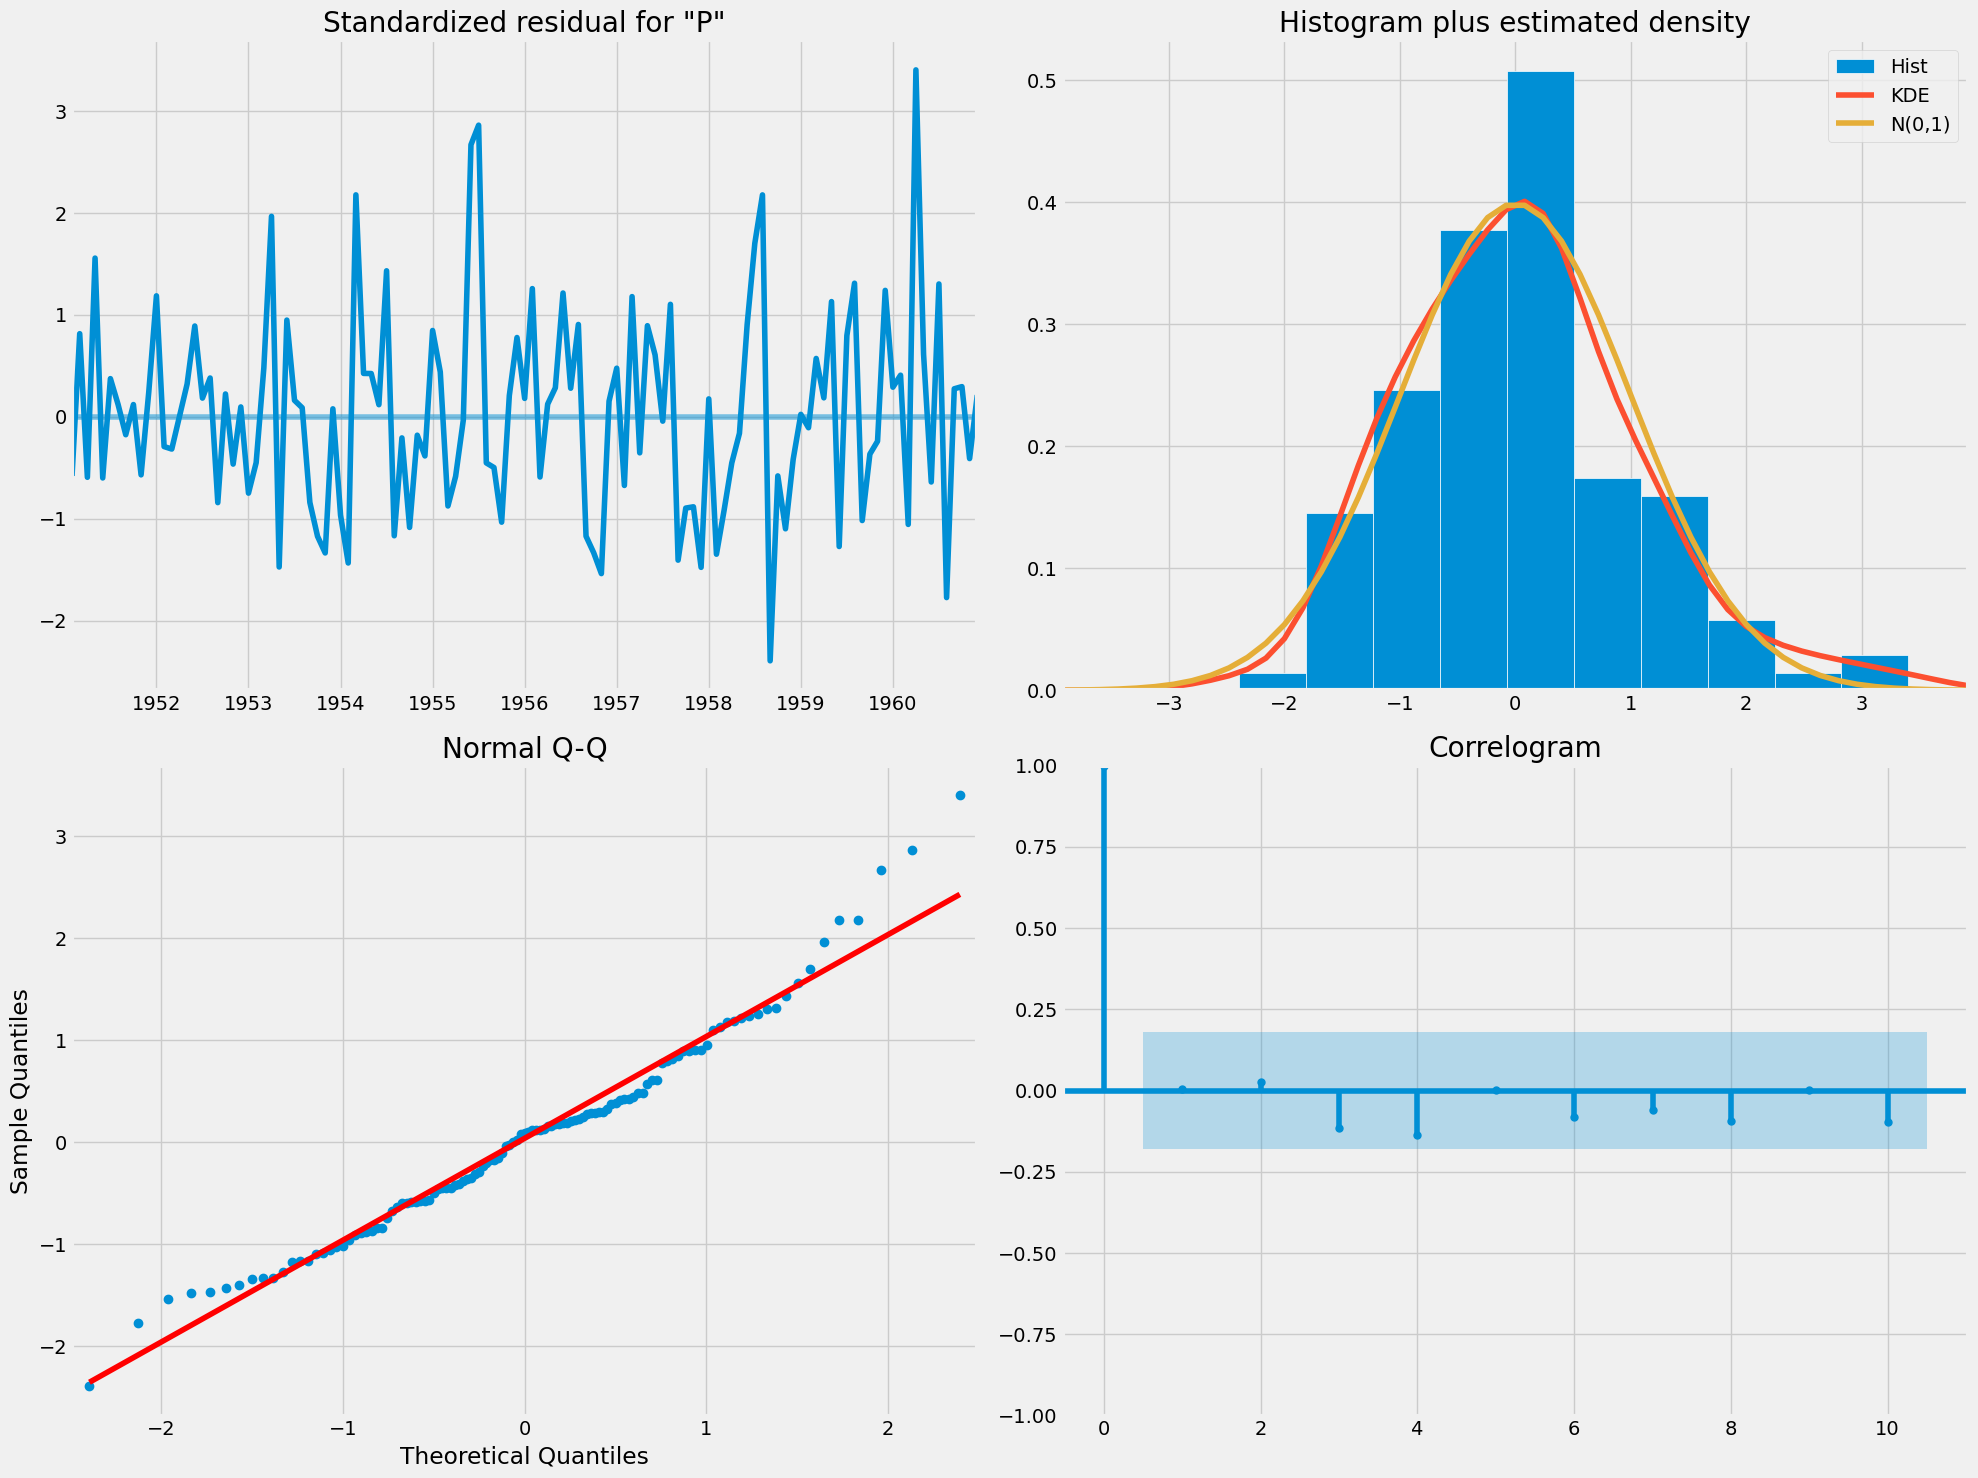

In [205]:
createModelSARIMAXex(model_AirPassengers, AirPassengers)

### Для нормализованного набора

c:\Users\leysh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\leysh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  131
Model:             SARIMAX(5, 1, 0)x(2, 1, 0, 24)   Log Likelihood                -425.204
Date:                            Sun, 23 Oct 2022   AIC                            868.407
Time:                                    01:48:40   BIC                            892.378
Sample:                                02-01-1950   HQIC                           878.123
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3563      0.519      0.687      0.492      -0.660       1.373
ar.L1         -1.3244      0.082    -16.066      0.000      -1.486      -1.163
ar.L2         -1.1315      0.121     -9.378      0.000      -1.368      -0.895
ar.L3         -0.9030      0.161     -5.596      0.000      -1.219      -0.587
ar.L4         -0.7242      0.168     -4.300      0.000      -1.054      -0.394
ar.L5         -0.3265      0.113     -2.901      0.004      -0.547      -0.106
ar.S.L24      -0.6948      0.101     -6.850      0.000      -0.894      -0.496
ar.S.L48      -0.4305      0.119     -3.606      0.000      -0.664      -0.196
sigma2       149.7748     20.614      7.266      0.000     109.372     190.178
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 7.18
Prob(Q):                              0.63   Prob(JB):                         0.03
Heteroskedasticity (H):               2.26   Skew:                             0.11
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

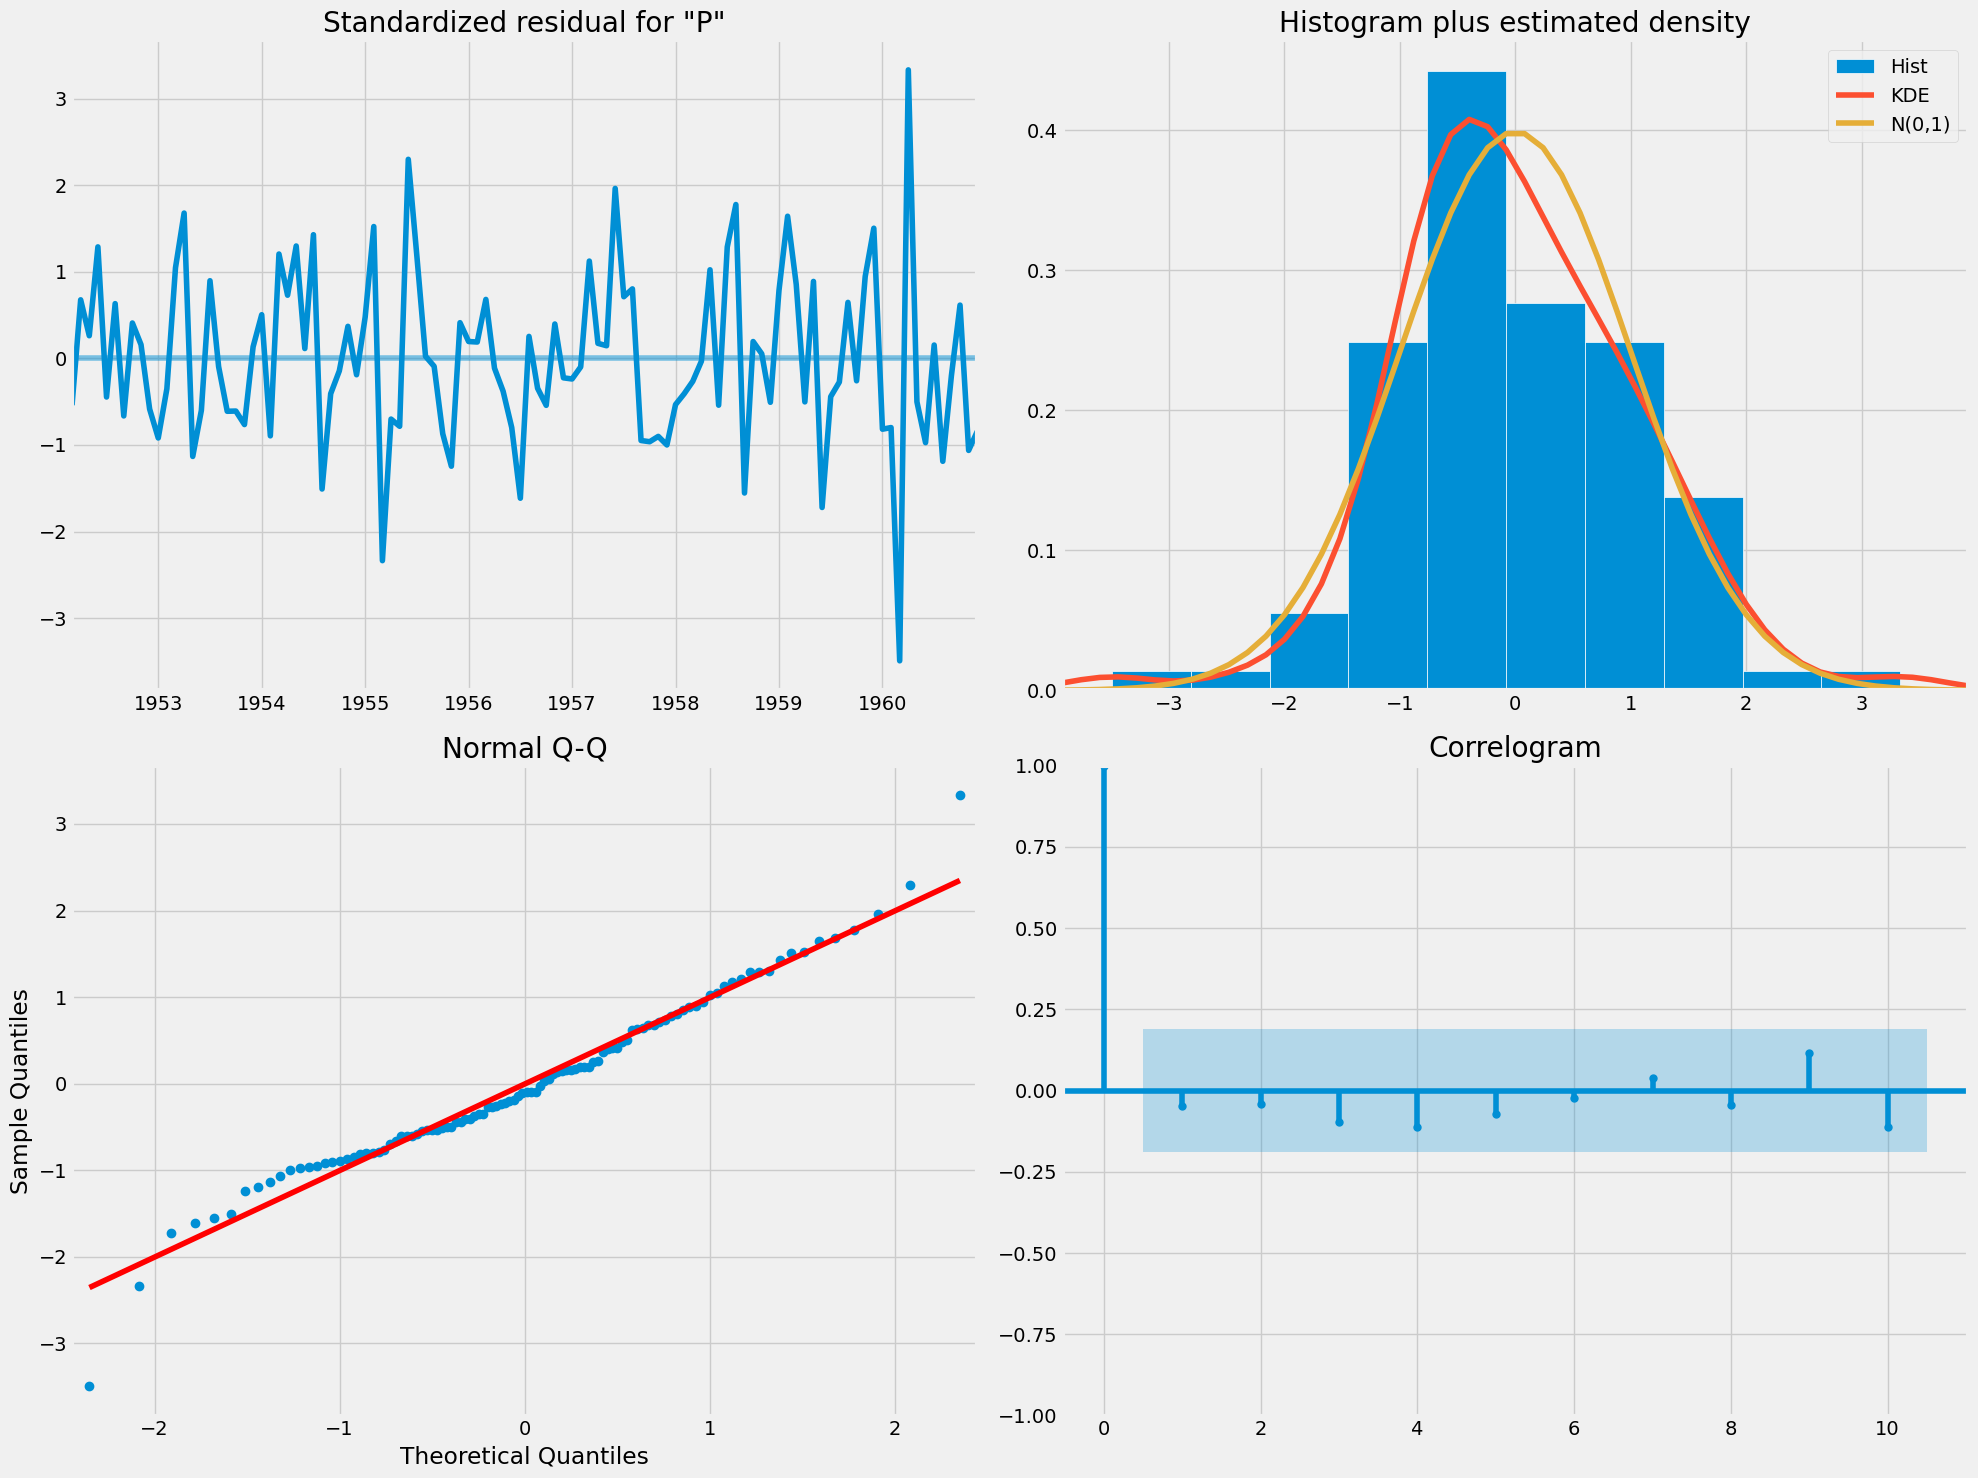

In [204]:
createModelSARIMAXex(model_AirPassengers_diff, AirPassengers_diff)

## Вывод 
Добавление дней недели к неочищенным данным улучшает точность модели, в остальных случаях ухудшает точность

# Dataset aus_employment


### Загрузка данных 

people_employed
date                       
1978-01-01           5985.7
1978-02-01           6040.6
1978-03-01           6054.2
1978-04-01           6038.3
1978-05-01           6031.3
...                     ...
1990-11-01           7941.2
1990-12-01           7668.8
1991-01-01           7739.3
1991-02-01           7746.5
1991-03-01           7750.5

[159 rows x 1 columns]

<AxesSubplot:xlabel='date'>

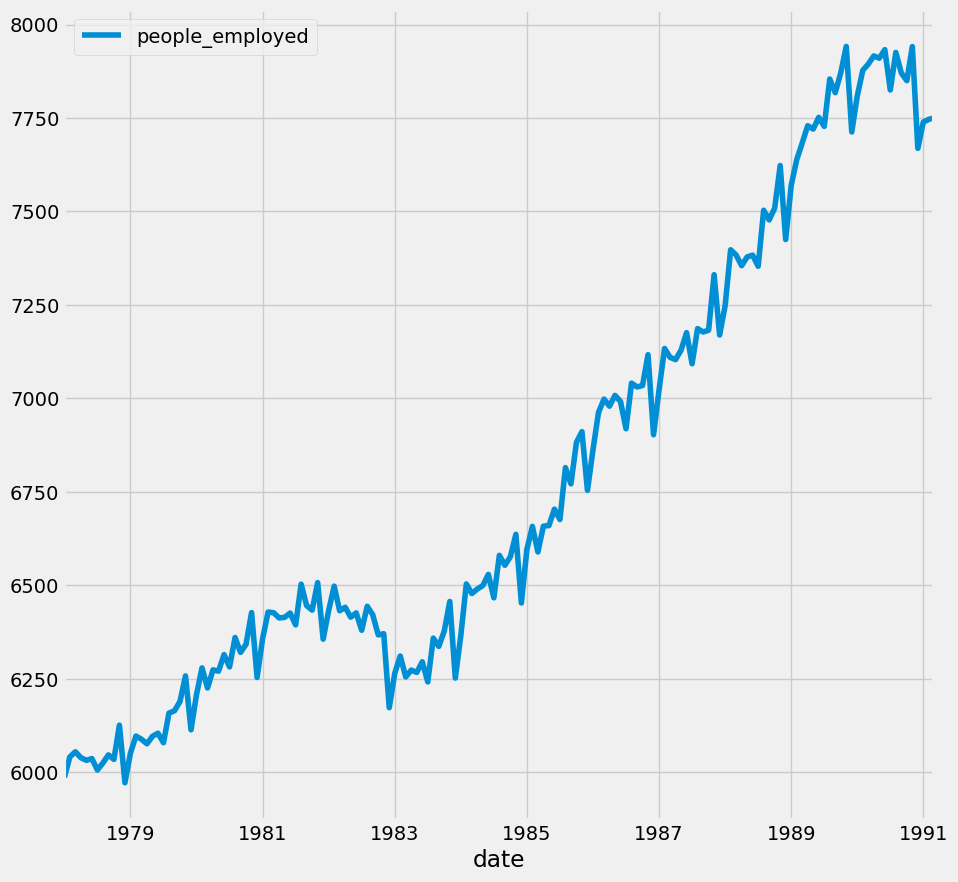

In [92]:
aus_employment = pd.read_csv('data/aus_employment.csv', index_col='date', parse_dates=True)
aus_employment = aus_employment.asfreq('MS')
display(aus_employment)
aus_employment.plot()

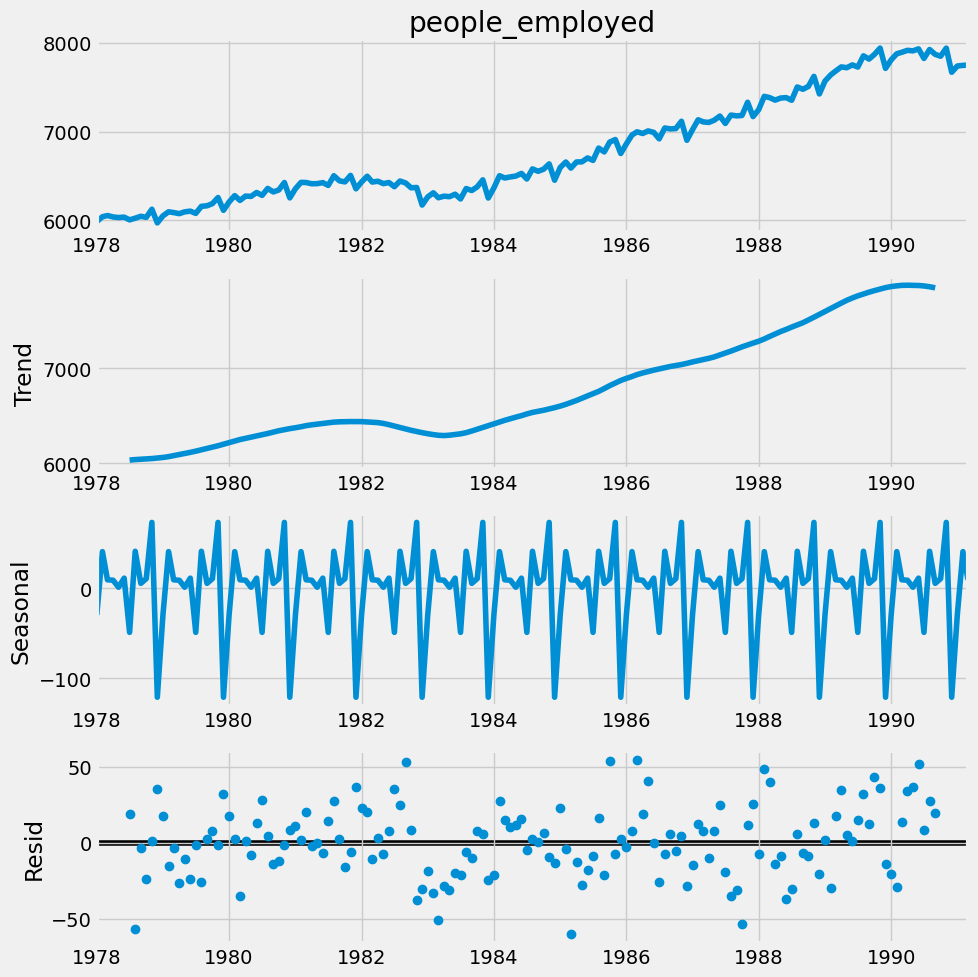

In [103]:
plotSeasonalDecompose(aus_employment, 'people_employed', 12)

### Очистка данных от сезональности и тренда

<AxesSubplot:xlabel='date'>

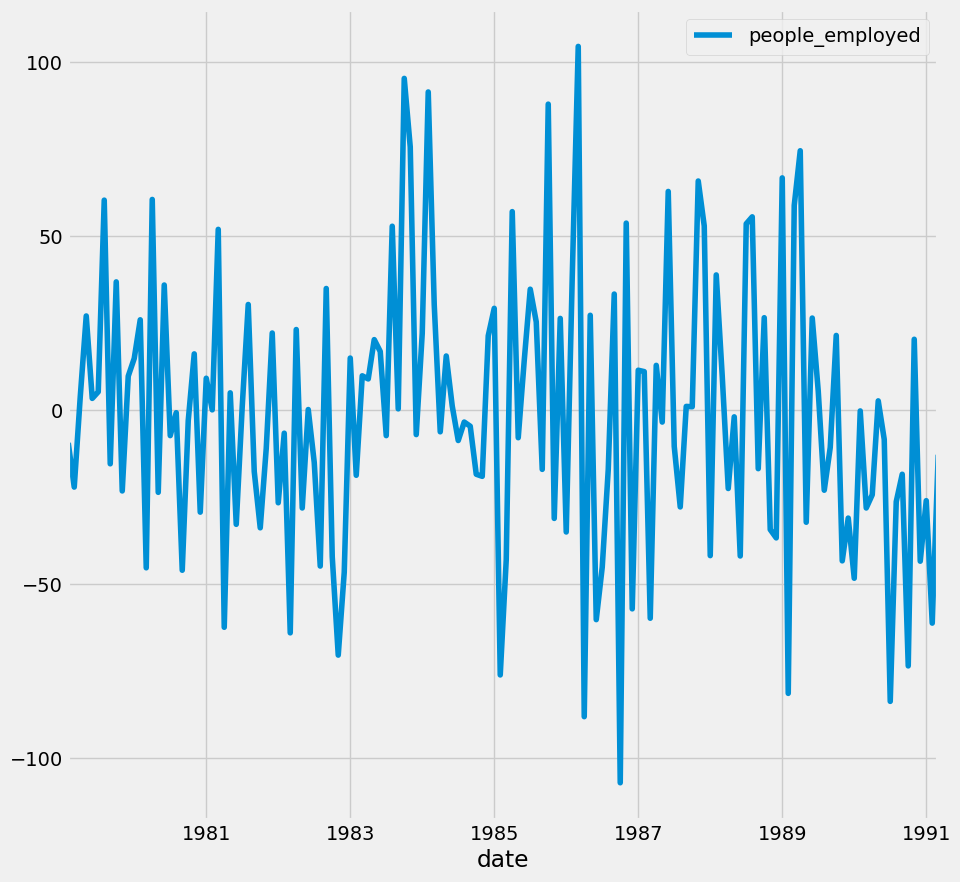

In [104]:
aus_employment_diff = dfNormalization(aus_employment, 12)
aus_employment_diff.plot()

## Подбор параметров auto_arima

### Для не нормализированного набора

In [153]:
model_aus_employment = pm.auto_arima(aus_employment,
                      seasonal=True, m=24,  # есть ли сезональность, размер сезональности
                      d=1, D=1,             # нужно ли дифференцировать данные (убрать (d)локальный, (D)глобальный тренд)
                      max_p=5, max_q=5,     # сколько вариантов перебирать (от 0 до N)
                      trace=True,           # вывод лога каждой итерации
                      error_action='ignore',
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[24]             : AIC=1339.849, Time=1.87 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=1381.717, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=1354.255, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=1346.982, Time=0.35 sec
 ARIMA(2,1,2)(0,1,1)[24]             : AIC=1337.900, Time=1.30 sec
 ARIMA(2,1,2)(0,1,0)[24]             : AIC=inf, Time=0.41 sec
 ARIMA(2,1,2)(0,1,2)[24]             : AIC=1339.857, Time=3.62 sec
 ARIMA(2,1,2)(1,1,0)[24]             : AIC=1346.312, Time=1.07 sec
 ARIMA(2,1,2)(1,1,2)[24]             : AIC=inf, Time=4.94 sec
 ARIMA(1,1,2)(0,1,1)[24]             : AIC=1336.769, Time=1.03 sec
 ARIMA(1,1,2)(0,1,0)[24]             : AIC=1369.911, Time=0.14 sec
 ARIMA(1,1,2)(1,1,1)[24]             : AIC=1338.744, Time=1.92 sec
 ARIMA(1,1,2)(0,1,2)[24]             : AIC=1338.749, Time=3.07 sec
 ARIMA(1,1,2)(1,1,0)[24]             : AIC=1344.682, Time=0.52 sec
 ARIMA(1,1,2)(1,1,2)[24]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  159
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 24)   Log Likelihood                -663.384
Date:                              Sun, 23 Oct 2022   AIC                           1336.769
Time:                                      01:44:39   BIC                           1351.258
Sample:                                  01-01-1978   HQIC                          1342.657
                                       - 03-01-1991                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9400      0.065     14.442      0.000       0.812       1.068
ma.L1         -1.1249      0.108    -10.414      0.000      -1.337      -0.913
ma.L2          0.3008      0.099      3.046      0.002       0.107       0.494
ma.S.L24      -0.6849      0.125     -5.486      0.000      -0.930      -0.440
sigma2      1042.3389    147.216      7.080      0.000     753.800    1330.878
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.88   Prob(JB):                         0.83
Heteroskedasticity (H):               1.67   Skew:                            -0.03
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

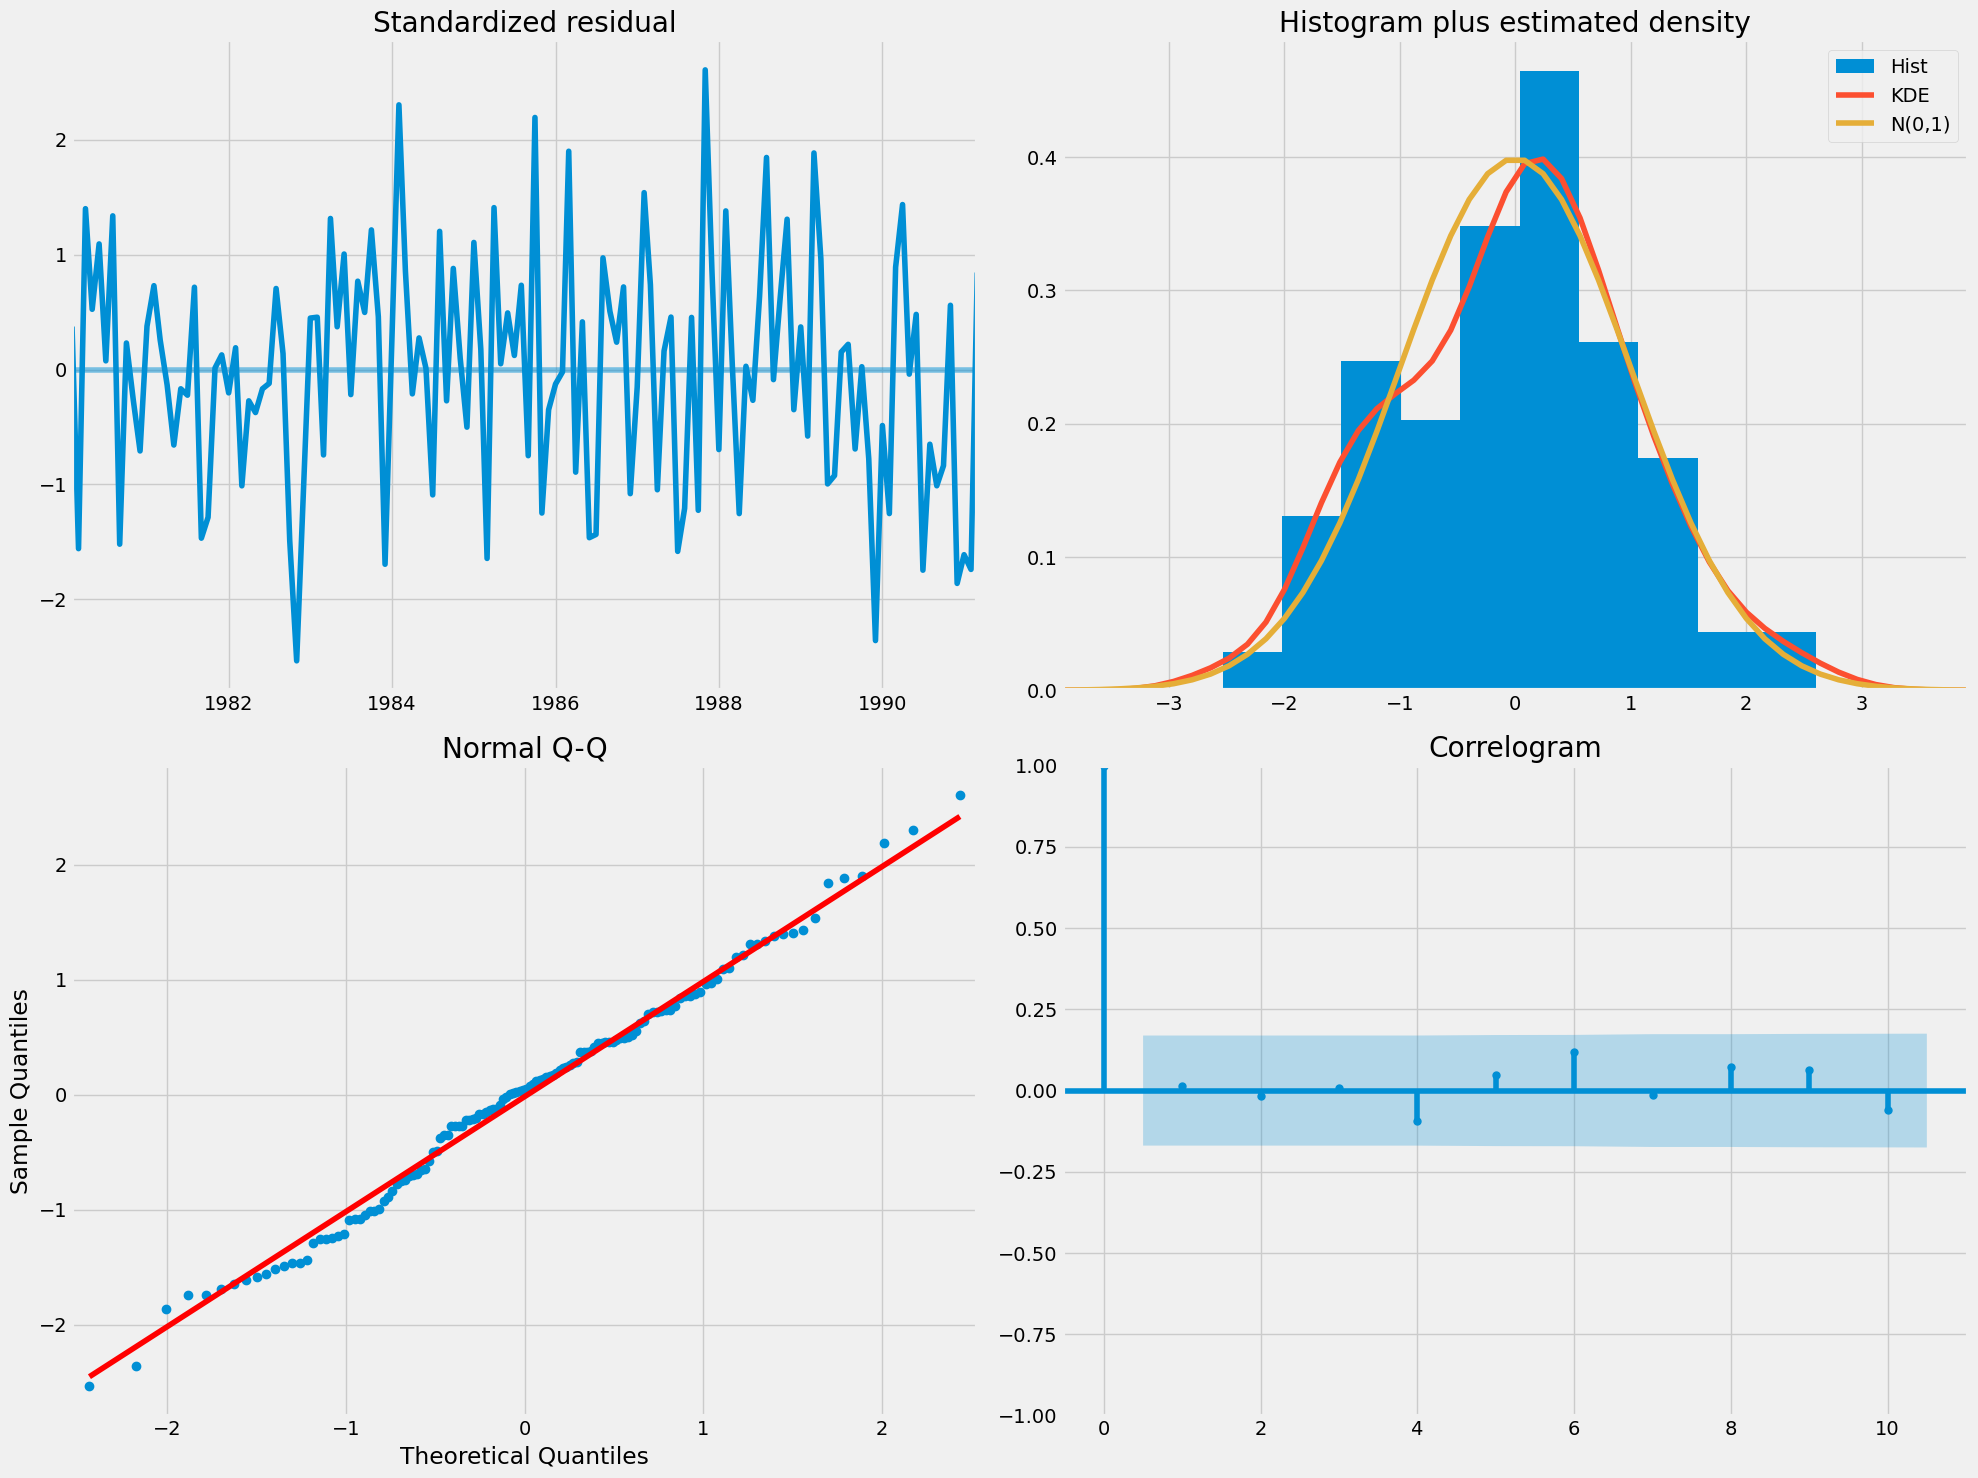

In [196]:
display(model_aus_employment.summary())
modelDiagnostics(model_aus_employment.fit(aus_employment))

### Для нормализированного набора

In [156]:
model_aus_employment_diff = pm.auto_arima(aus_employment_diff,
                      seasonal=True, m=24,  # есть ли сезональность, размер сезональности
                      d=1, D=1,             # нужно ли дифференцировать данные (убрать (d)локальный, (D)глобальный тренд)
                      max_p=5, max_q=5,     # сколько вариантов перебирать (от 0 до N)
                      trace=True,           # вывод лога каждой итерации
                      error_action='ignore',
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[24]             : AIC=inf, Time=1.95 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=1416.556, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=1335.881, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=0.58 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=1369.161, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=1330.428, Time=0.71 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=3.11 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=1327.698, Time=0.89 sec
 ARIMA(1,1,0)(0,1,1)[24]             : AIC=inf, Time=0.45 sec
 ARIMA(1,1,0)(1,1,2)[24]             : AIC=inf, Time=1.93 sec
 ARIMA(1,1,0)(0,1,2)[24]             : AIC=1327.713, Time=0.95 sec
 ARIMA(1,1,0)(2,1,2)[24]             : AIC=inf, Time=3.89 sec
 ARIMA(0,1,0)(1,1,1)[24]             : AIC=1375.929, Time=0.43 sec
 ARIMA(2,1,0)(1,1,1)[24]             : AIC=inf, Time=1.43 sec
 ARIMA(1,1,1)(1,1,1)[24]             : AIC=inf, Time=1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  146
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 24)   Log Likelihood                -659.849
Date:                              Sun, 23 Oct 2022   AIC                           1327.698
Time:                                      01:44:59   BIC                           1338.882
Sample:                                  02-01-1979   HQIC                          1332.240
                                       - 03-01-1991                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5824      0.081     -7.180      0.000      -0.741      -0.423
ar.S.L24      -0.0650      0.172     -0.379      0.705      -0.402       0.272
ma.S.L24      -0.7422      0.307     -2.415      0.016      -1.345      -0.140
sigma2      2681.9870    501.621      5.347      0.000    1698.828    3665.146
===================================================================================
Ljung-Box (L1) (Q):                  10.31   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.00   Prob(JB):                         0.27
Heteroskedasticity (H):               1.18   Skew:                            -0.24
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

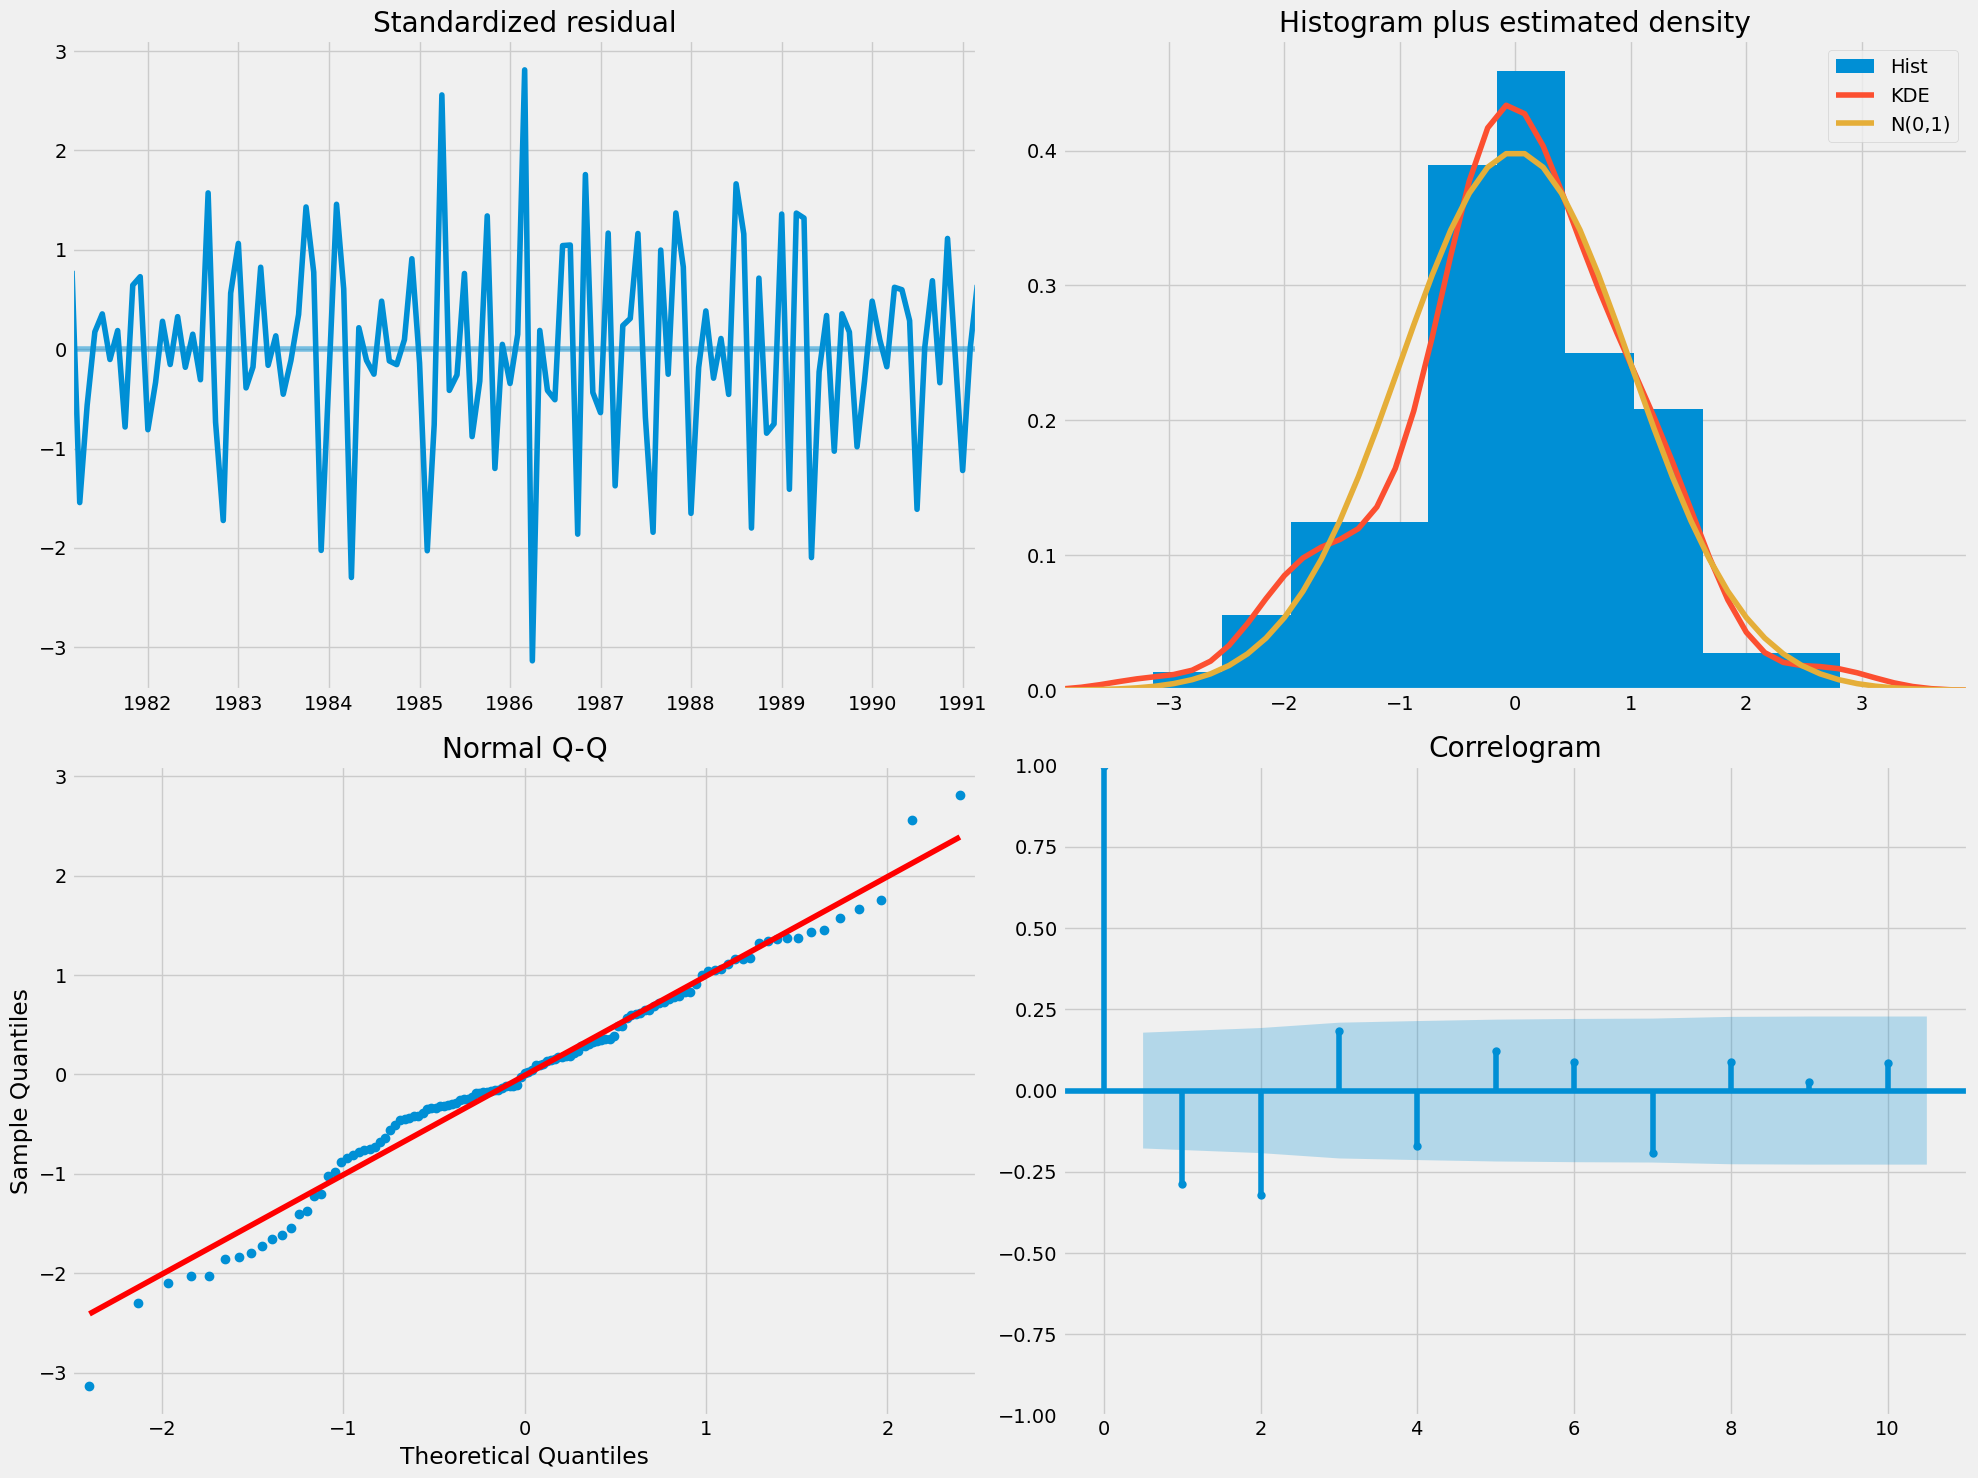

In [197]:
display(model_aus_employment_diff.summary())
modelDiagnostics(model_aus_employment_diff.fit(aus_employment_diff))

## Добавим день недели 

### Для не нормализованного набора

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      people_employed   No. Observations:                  159
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 24)   Log Likelihood                -663.299
Date:                              Sun, 23 Oct 2022   AIC                           1338.598
Time:                                      01:42:47   BIC                           1355.985
Sample:                                  01-01-1978   HQIC                          1345.664
                                       - 03-01-1991                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3199      0.884     -0.362      0.717      -2.052       1.413
ar.L1          0.9398      0.065     14.388      0.000       0.812       1.068
ma.L1         -1.1221      0.108    -10.369      0.000      -1.334      -0.910
ma.L2          0.2982      0.100      2.985      0.003       0.102       0.494
ma.S.L24      -0.6845      0.128     -5.359      0.000      -0.935      -0.434
sigma2      1041.3316    148.042      7.034      0.000     751.174    1331.489
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.39
Prob(Q):                              0.87   Prob(JB):                         0.82
Heteroskedasticity (H):               1.62   Skew:                            -0.03
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

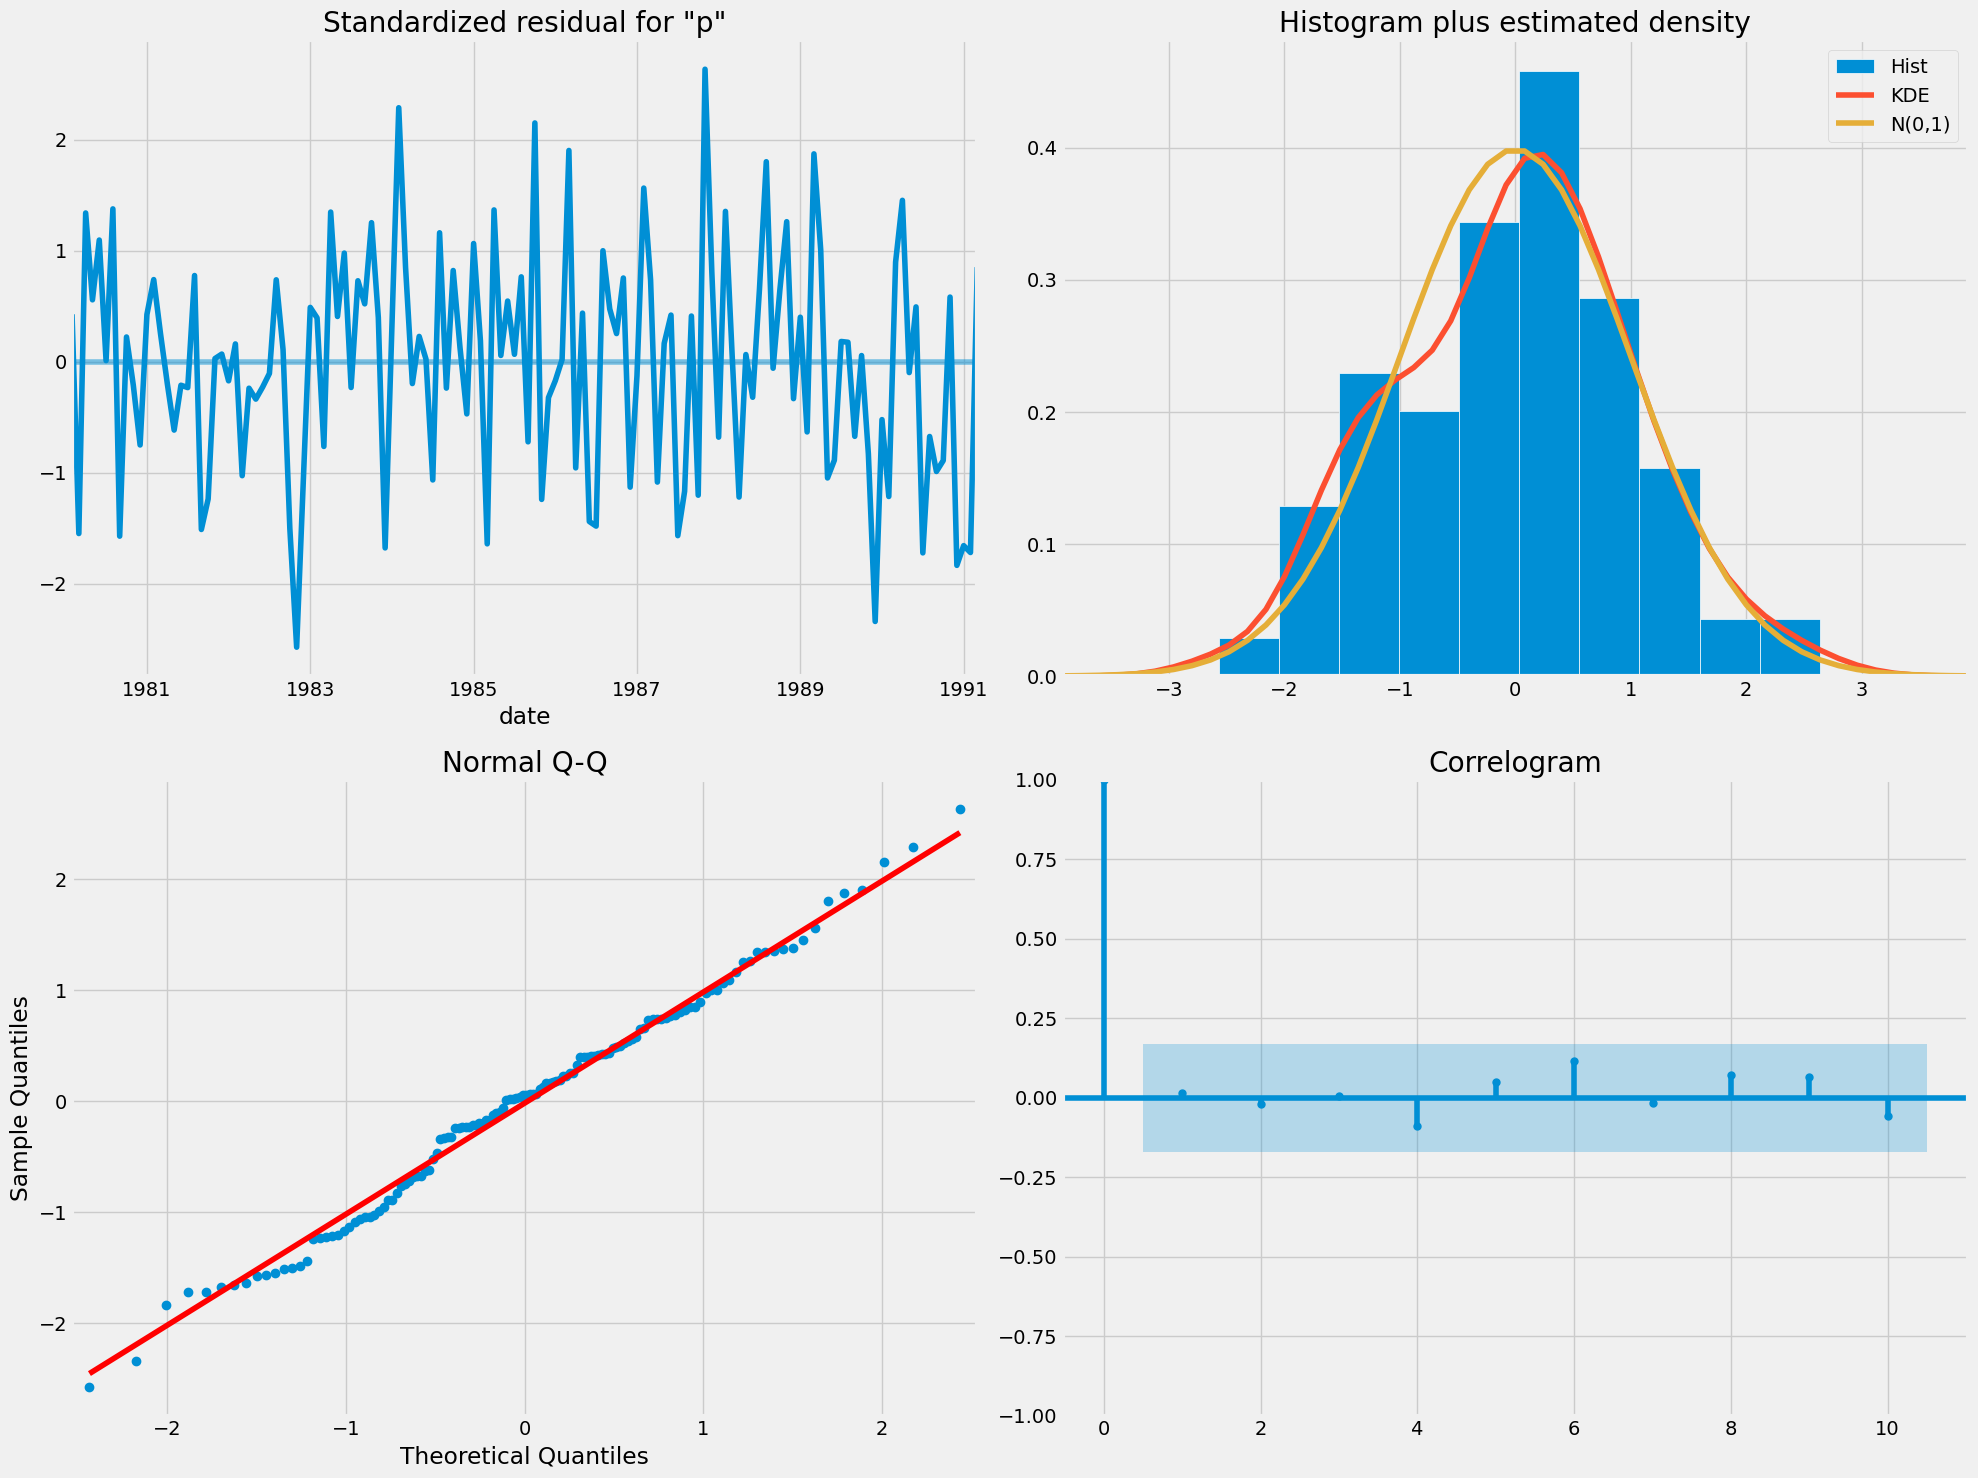

In [194]:
createModelSARIMAXex(model_aus_employment, aus_employment)

### Для нормализованного набора

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      people_employed   No. Observations:                  146
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 24)   Log Likelihood                -659.295
Date:                              Sun, 23 Oct 2022   AIC                           1328.591
Time:                                      01:42:54   BIC                           1342.570
Sample:                                  02-01-1979   HQIC                          1334.268
                                       - 03-01-1991                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.5622      1.581      0.988      0.323      -1.537       4.662
ar.L1         -0.5856      0.088     -6.640      0.000      -0.758      -0.413
ar.S.L24      -0.0577      0.191     -0.302      0.762      -0.432       0.316
ma.S.L24      -0.7268      0.324     -2.243      0.025      -1.362      -0.092
sigma2      2686.8663    504.384      5.327      0.000    1698.291    3675.442
===================================================================================
Ljung-Box (L1) (Q):                  10.24   Jarque-Bera (JB):                 1.86
Prob(Q):                              0.00   Prob(JB):                         0.39
Heteroskedasticity (H):               1.14   Skew:                            -0.21
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

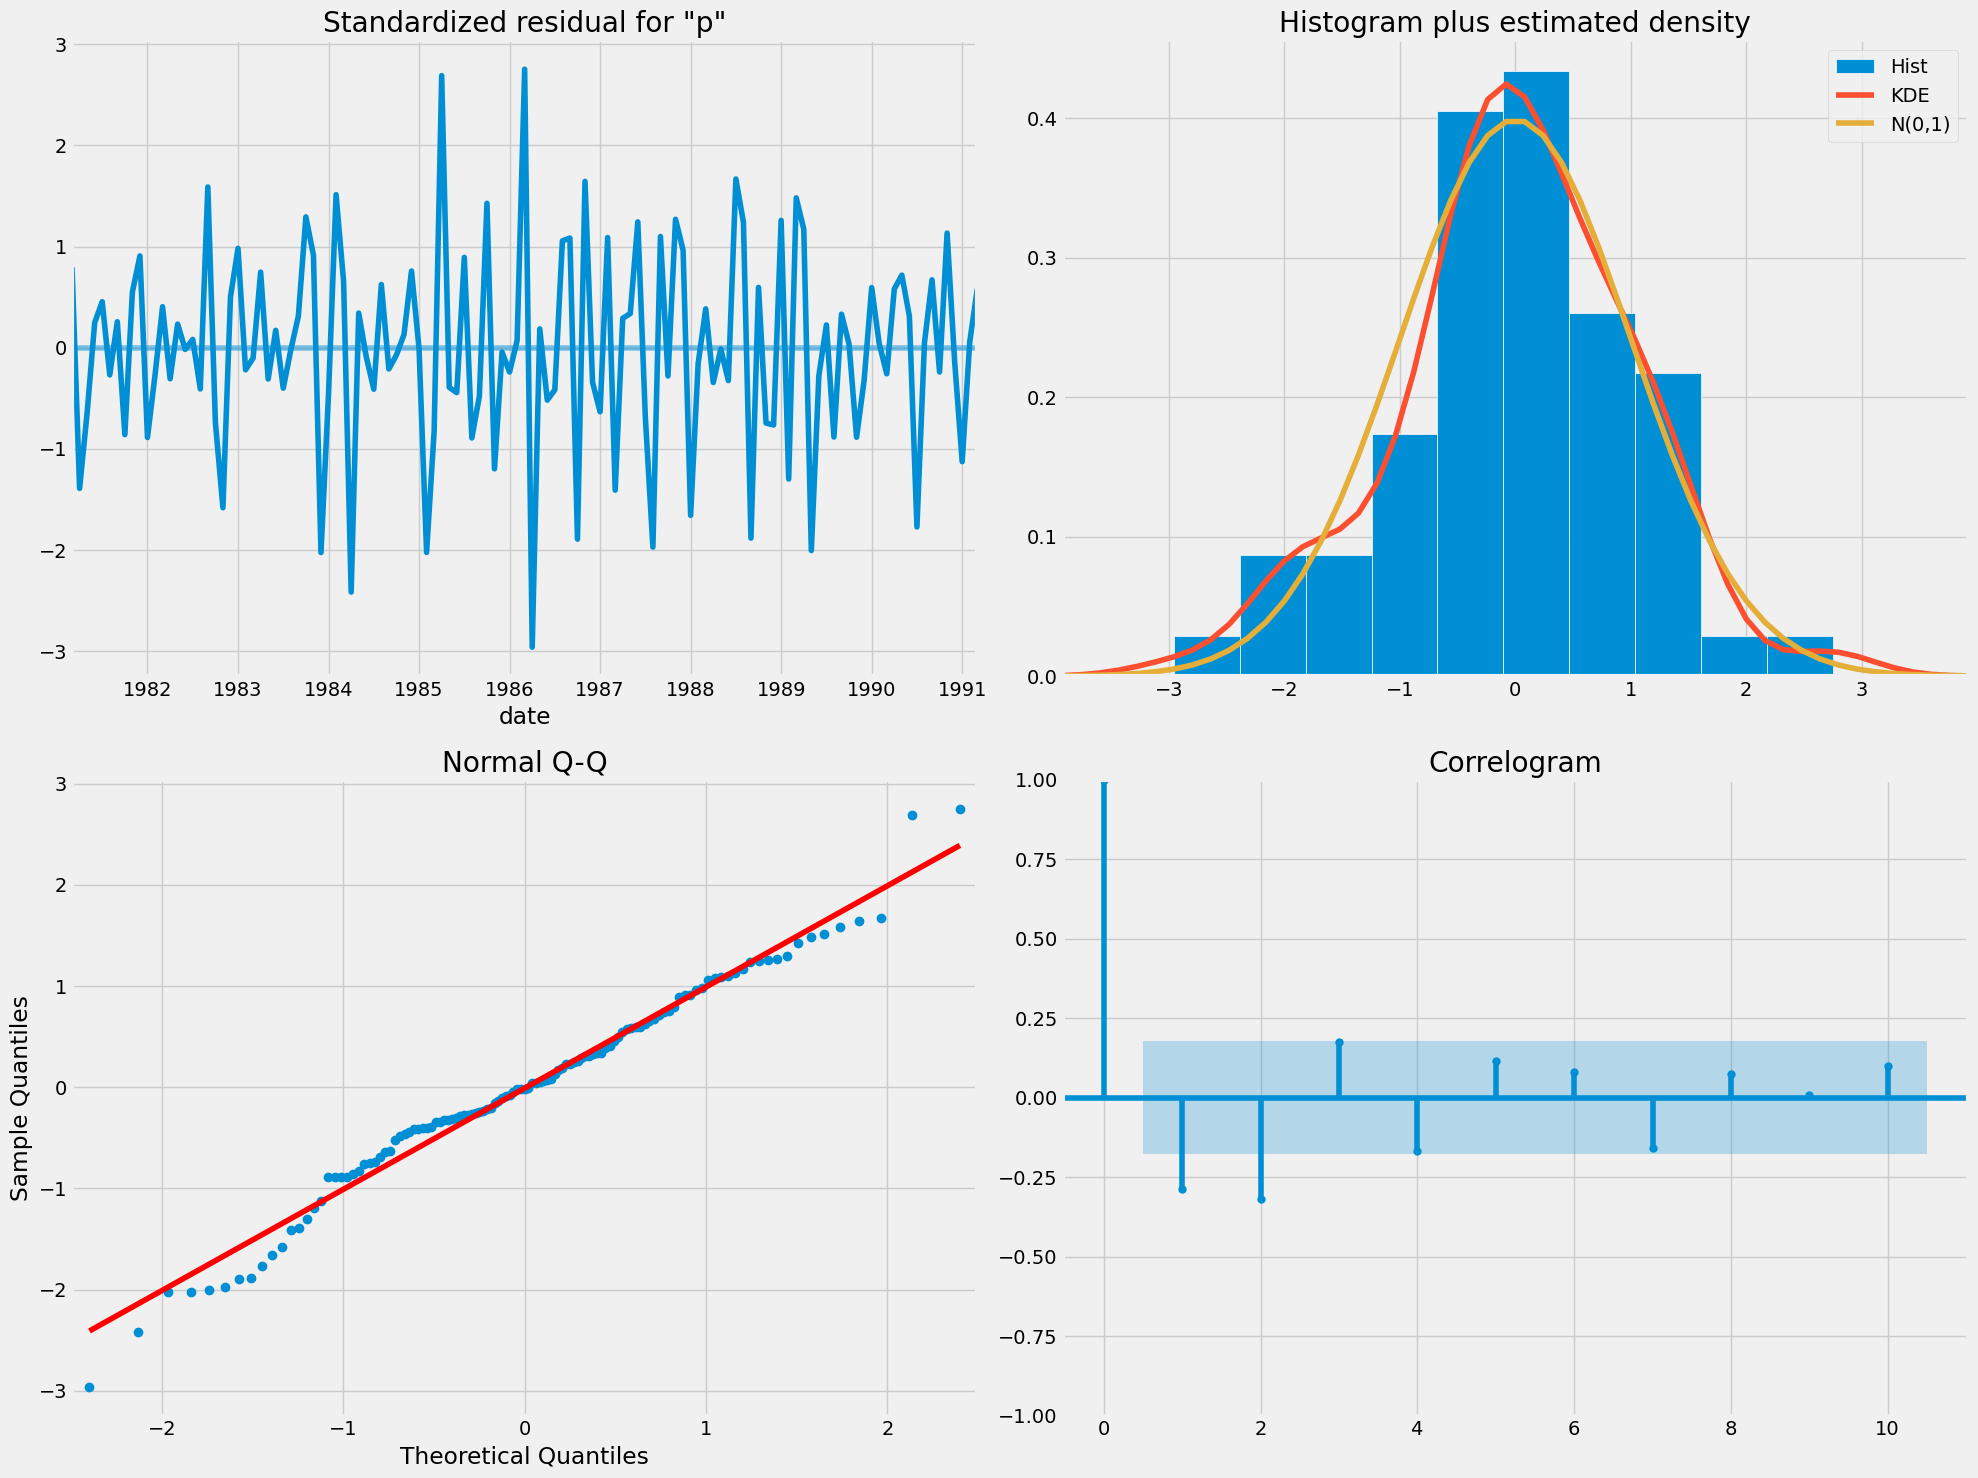

In [195]:
createModelSARIMAXex(model_aus_employment_diff, aus_employment_diff)

## Вывод 
Добавление дней недели ухудшает точность моделей